# Importando dados

importando as bibliotecas que usaremos no ao longo do projeto.

In [213]:
# Bibliotecas padrão para manipulação dos dados
import pandas as pd
import numpy as np
import datetime as dt

# Visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import missingno

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import (train_test_split, cross_val_score, StratifiedKFold, 
                                     GridSearchCV, KFold, RandomizedSearchCV)

# Testes de Hipoteses (Estatísticos)
from scipy import stats
from scipy.stats import f_oneway, kruskal

import warnings
warnings.filterwarnings('ignore')

In [214]:
# Importando o dataframe
df_original = pd.read_csv('C:/Users/winic/Documents/LightHouse/teste_indicium_precificacao.csv', sep = ',')

In [215]:
# Criando uma cópia para casos de fazer alterações, ainda teremos o principal
df = df_original.copy()

# Funções Auxiliares

In [216]:
def excluir_colunas(df, colunas):

  '''recebe um dataframe (df) e uma lista de colunas (colunas) como argumentos.
     A função exclui as colunas especificadas do dataframe e retorna o dataframe resultante.

     A função utiliza o método drop do pandas para eliminar as colunas indicadas pelo parâmetro colunas.
     O parâmetro axis=1 é utilizado para indicar que as colunas devem ser eliminadas, em oposição às linhas.'''

  df = df.drop(colunas, axis=1)
  return df

In [217]:
# Define uma função chamada label_encode_columns
def label_encode_columns(df, column_names):
    '''A função recebe dois argumentos: df, que é o dataframe, e column_names, 
       que é uma lista de nomes de colunas a serem codificadas. 
       A função cria uma instância de LabelEncoder chamada lab e, 
       para cada coluna na lista column_names, 
       aplica o método fit_transform da instância lab aos valores da coluna, 
       substituindo-os pelos valores codificados.'''
    # Cria uma instância da classe LabelEncoder
    lab = LabelEncoder()
    # Para cada nome de coluna na lista column_names
    for column_name in column_names:
        # Aplica o método fit_transform da instância lab aos valores da coluna
        # e substitui os valores originais pelos valores codificados
        df[column_name] = lab.fit_transform(df[column_name].values)
    # Retorna o dataframe modificado
    return df

In [218]:
def remover_recursos_correlacionados(df, limite = 0.9):
    '''identifica recursos (colunas) que estão altamente correlacionados entre si dentro de um DataFrame.
       A lista recursos_correlacionados contém pares de recursos correlacionados,
       enquanto o conjunto recursos_a_remover contém os recursos que devem ser removidos por terem alta correlação com outros recursos.'''
    recursos_correlacionados = []
    recursos_a_remover = set()

    matriz_de_correlação = df.corr()

    for i in range(len(matriz_de_correlação.columns)):
        for j in range(i):
            if abs(matriz_de_correlação.iloc[i, j]) > limite:
                nomedacoluna = matriz_de_correlação.columns[i]

                recursos_correlacionados.append((matriz_de_correlação.columns[i], matriz_de_correlação.columns[j]))

                recursos_a_remover.add(nomedacoluna)

    return recursos_correlacionados, recursos_a_remover

In [219]:
def to_one_hot_encoding(df, col_list, drop_original = True):
    '''Retorna uma cópia do DataFrame original com as colunas categóricas codificadas usando a codificação one-hot.
    Parâmetros:
    df: o DataFrame original
    col_list: a lista de colunas categóricas que devem ser codificadas
    drop_original: um booleano que indica se as colunas originais devem ser removidas ou não
    '''

    # Fazendo uma cópia do DataFrame original para não alterar os dados originais
    df_copy = df.loc[:]

    # Usando a função get_dummies do Pandas para gerar as colunas codificadas
    df_one_hot = pd.get_dummies(df_copy[col_list], drop_first=False, dtype=int)

    # Alterando os nomes das colunas para ficarem em letras minúsculas e sem espaços
    df_one_hot.columns = df_one_hot.columns.str.lower().str.replace(' ','_')

    # Juntando as colunas codificadas com o DataFrame original
    df_copy = df_copy.join(df_one_hot)
    
    # Removendo as colunas originais se drop_original for True
    if drop_original:
        df_copy = df_copy.drop(col_list, axis=1)

    # Retornando o DataFrame com as colunas codificadas
    return df_copy

In [220]:
# Função para interpretação dos resultados dos testes de normalidade
def interpretar_normalidade(shapiro, ks, ad, alpha=0.05):
    conclusao = ""
    if shapiro.pvalue < alpha:
        conclusao += "Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.\n"
    else:
        conclusao += "Shapiro-Wilk Teste: Não rejeitar hipótese nula de normalidade.\n"
    
    if ks.pvalue < alpha:
        conclusao += "Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.\n"
    else:
        conclusao += "Kolmogorov-Smirnov Teste: Não rejeitar hipótese nula de normalidade.\n"
    
    if ad.statistic > ad.critical_values[2]:
        conclusao += "Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.\n"
    else:
        conclusao += "Anderson-Darling Teste: Não rejeitar hipótese nula de normalidade.\n"
    
    return conclusao

# Análise Explratória dos dados (EDA)

In [221]:
# Visualizando as 5 primeiras colunas para nos familiarizarmos com os dados
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [222]:
# Verificando o tamanho do Dataframe
df.shape

(48894, 16)

In [223]:
# Verificando os tipos das variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

In [224]:
# Verificando a quantidade de valores faltantes
df.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

In [225]:
# Verificando a porcentagem dos valores faltantes
(df.isnull().sum()/df.shape[0]*100).round(3)

id                                0.000
nome                              0.033
host_id                           0.000
host_name                         0.043
bairro_group                      0.000
bairro                            0.000
latitude                          0.000
longitude                         0.000
room_type                         0.000
price                             0.000
minimo_noites                     0.000
numero_de_reviews                 0.000
ultima_review                    20.559
reviews_por_mes                  20.559
calculado_host_listings_count     0.000
disponibilidade_365               0.000
dtype: float64

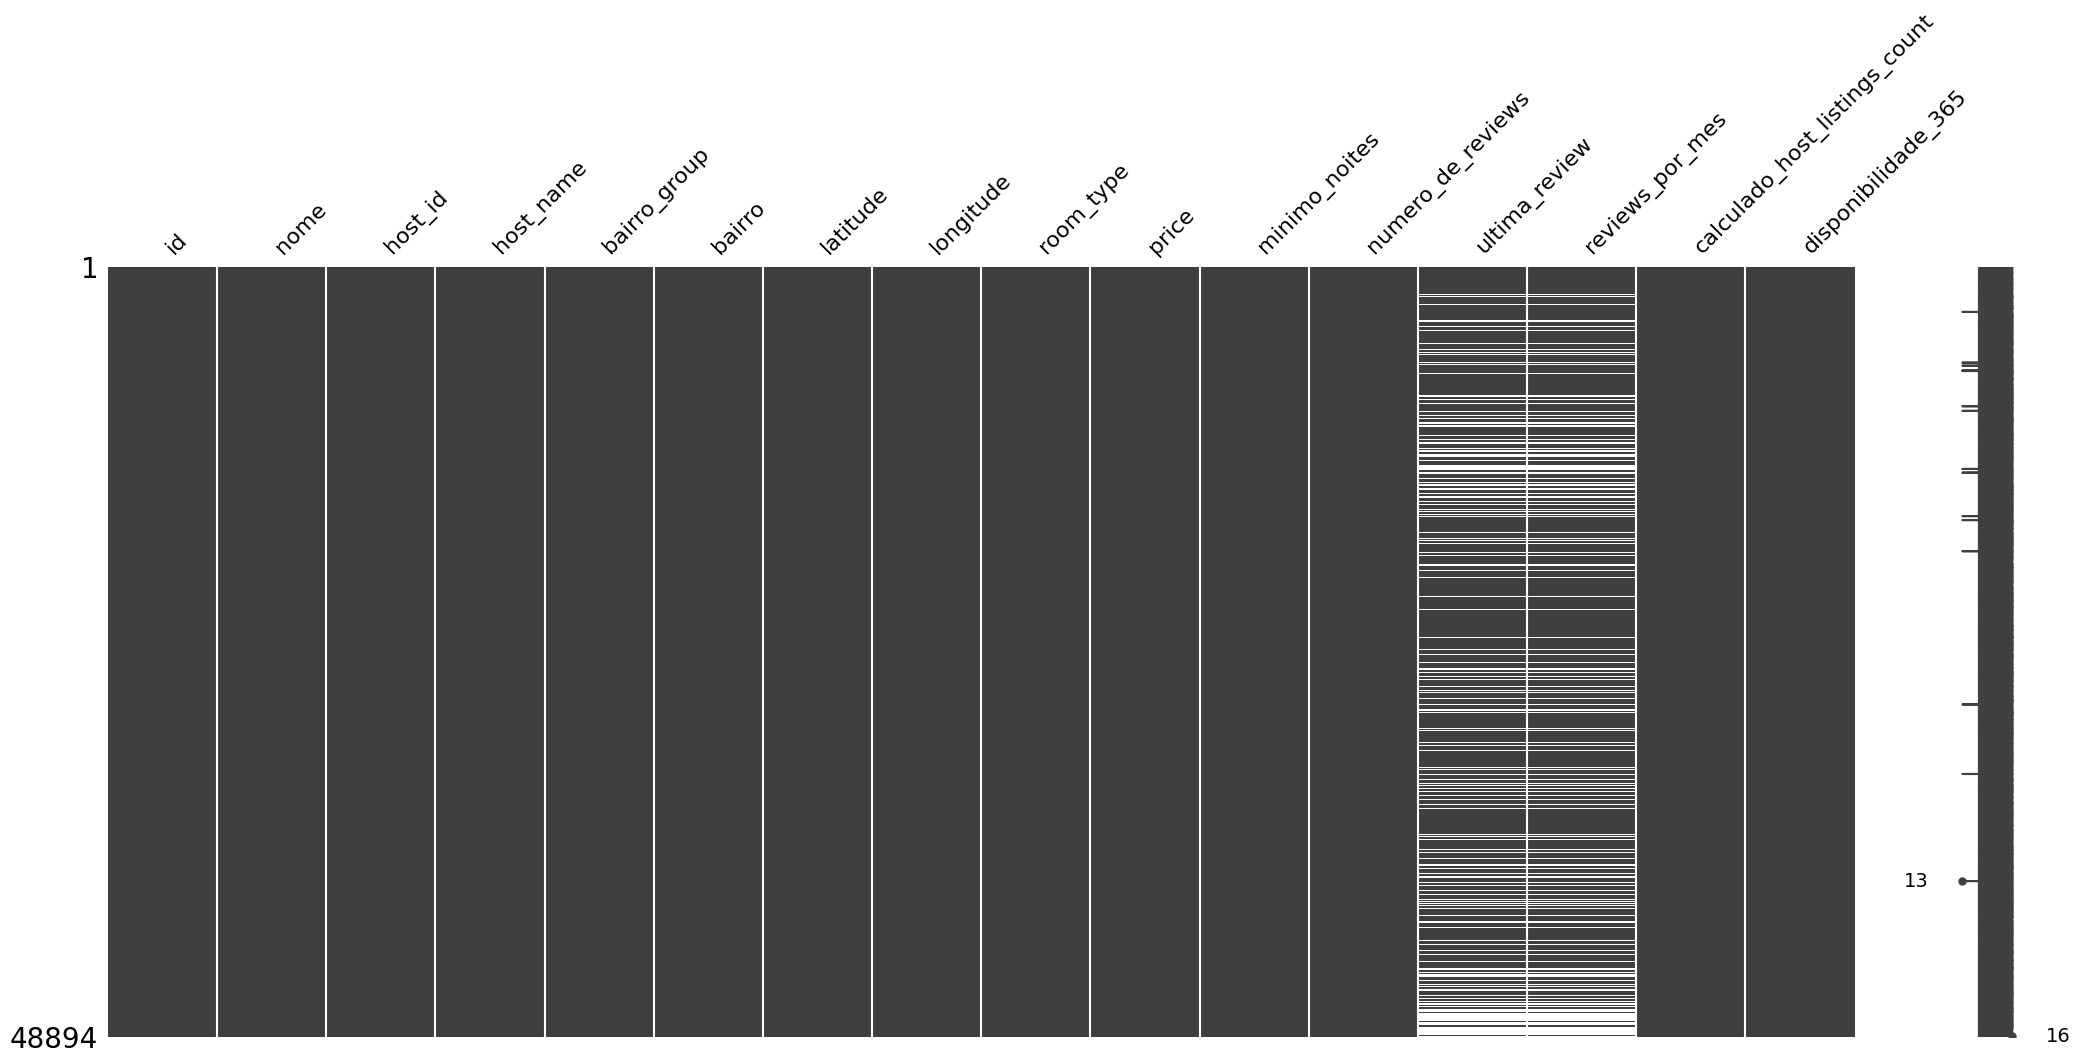

In [226]:
missingno.matrix(df);

Podemos observar que as variáveis última_review e reviews_por_mês são as que têm mais valores ausentes, com aproximadamente 20% em cada uma.

## Analisando os diferentes bairros

In [227]:
# Verificando quantas ocorrências existem em cada variável
df.nome.value_counts().head()

nome
Hillside Hotel                      18
Home away from home                 17
New york Multi-unit building        16
Brooklyn Apartment                  12
Loft Suite @ The Box House Hotel    11
Name: count, dtype: int64

In [228]:
df.bairro.value_counts().head()

bairro
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Name: count, dtype: int64

In [229]:
df.bairro_group.value_counts()

bairro_group
Manhattan        21661
Brooklyn         20103
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

Podemos notar que a análise dos grupos de bairros faz mais sentido, pois eles apresentam uma quantidade menor de variáveis a serem analisadas.

In [230]:
df.groupby("bairro_group")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
bairro_group,,,,,,,,
Bronx,1091.0,87.496792,106.709349,0.0,45.0,65.0,99.0,2500.0
Brooklyn,20103.0,124.381983,186.878105,0.0,60.0,90.0,150.0,10000.0
Manhattan,21661.0,196.875814,291.383183,0.0,95.0,150.0,220.0,10000.0
Queens,5666.0,99.517649,167.102155,10.0,50.0,75.0,110.0,10000.0
Staten Island,373.0,114.812332,277.620403,13.0,50.0,75.0,110.0,5000.0


Algumas conclusões:

* O bairro mais caro em média é Manhattan, com um preço médio de 196.88 dólares. O bairro mais barato em média é Bronx, com um preço médio de 87.50 dólares.
* O bairro com maior variação de preços também é Manhattan, com um desvio padrão de 291.38 dólares. Isso significa que os preços dos imóveis nesse bairro são mais dispersos em torno da média. O bairro com menor variação de preços é Bronx, com um desvio padrão de 106.71 dólares. Isso significa que os preços dos imóveis nesse bairro são mais concentrados em torno da média.
* O bairro com maior valor máximo é Manhattan, com um preço máximo de 10.000 dólares. O bairro com menor valor mínimo é Bronx, com um preço mínimo de 0 dólar. Isso pode indicar que há imóveis gratuitos ou muito baratos nesse bairro, ou que há algum erro nos dados (o mais provável).
* O bairro com maior número de locações é Brooklyn, com 20.103. O bairro com menor número de locações é Staten Island, com apenas 373.
* O bairro com maior proporção de locações em relação ao total é Manhattan, com 38.6% das locações. O bairro com menor proporção em relação ao total é Staten Island, com apenas 0.7%.

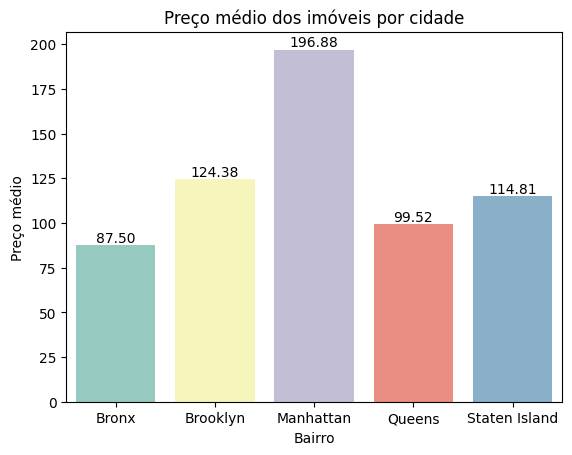

In [231]:
# Agrupar o dataframe por cidade e calcular a média do preço
df_grouped = df.groupby('bairro_group')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Bairro')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio dos imóveis por cidade')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:
* O preço médio dos imóveis varia consideravelmente entre os diferentes bairros. Manhattan tem o preço médio mais alto, seguido por Brooklyn, Staten Island, Queens e Bronx.
* O preço médio de Manhattan é mais do que o dobro do preço médio de Bronx, o bairro mais barato. Isso indica uma grande disparidade econômica e social entre os bairros.
* O preço médio de Staten Island é maior do que o de Queens, apesar de ser um bairro mais afastado e menos populoso. Isso pode sugerir uma maior qualidade de vida ou uma menor oferta de imóveis no bairro.
* O preço médio de Brooklyn é próximo do de Staten Island, mas com uma maior variação. Isso pode refletir a diversidade cultural e arquitetônica do bairro, que possui áreas mais nobres e outras mais simples.

Vamos realizar um teste de hipóteses para verificar se há diferenças entre as médias dos preços dos imóveis nos bairros de Nova York. O teste escolhido vai depender do tipo de dados: se eles tiverem uma distribuição normal, usaremos o ANOVA, se não, aplicaremos o teste de Kruskal-Wallis.

Esses testes são ferramentas importantes porque ajudam a entender se as diferenças entre os preços dos bairros são reais ou se podem ter acontecido por acaso. Isso é útil para:

* Entender como o mercado imobiliário se comporta e o que os consumidores preferem;

* Planejar melhor estratégias de marketing e vendas para quem quer vender imóveis;

* Estimar valores mais justos para imóveis em diferentes regiões.

Se o teste ANOVA ou Kruskal-Wallis mostrar que o valor-p é menor que o nível de significância escolhido (normalmente 0.05), isso significa que há diferenças significativas entre os preços médios dos bairros. Mas, se o valor-p for maior que 0.05, não teremos evidências para dizer que os preços são diferentes.

Essa análise é uma forma de usar os dados para tirar conclusões úteis e tomar decisões melhores, tanto para quem está alugando quanto para quem quer alugar imóveis.

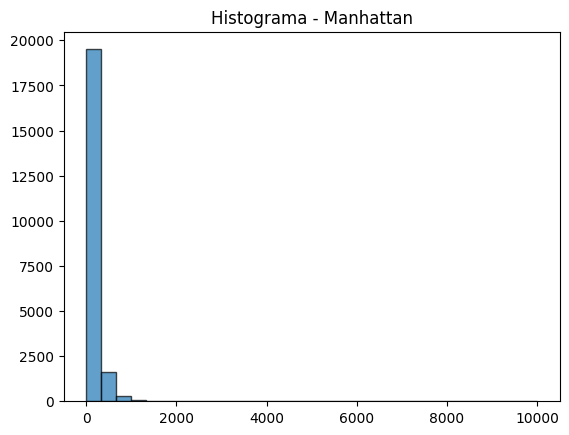

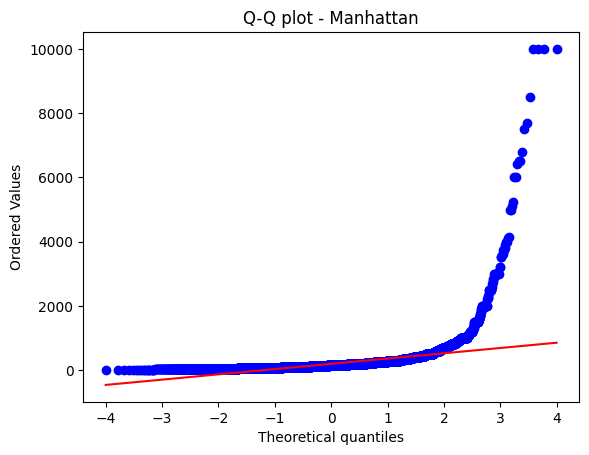

Manhattan - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.



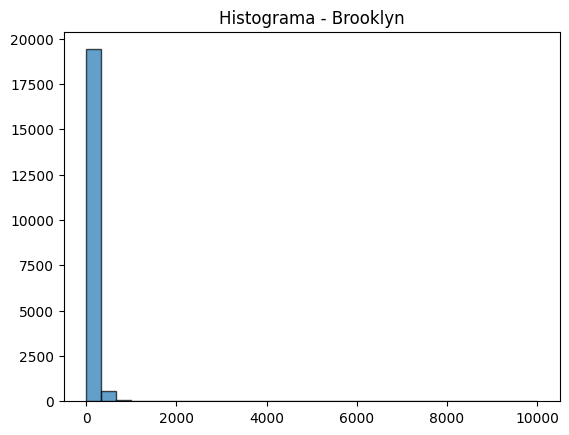

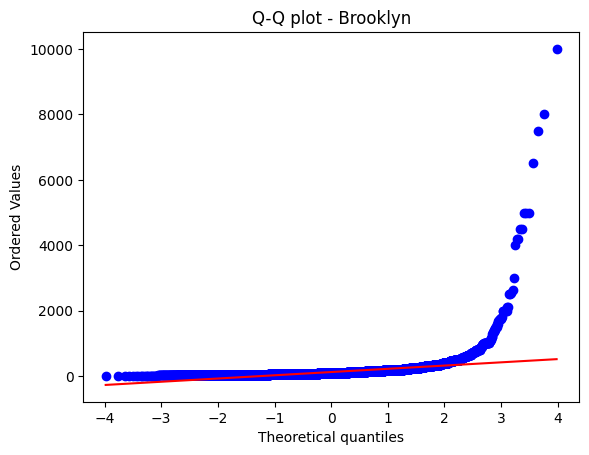

Brooklyn - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.



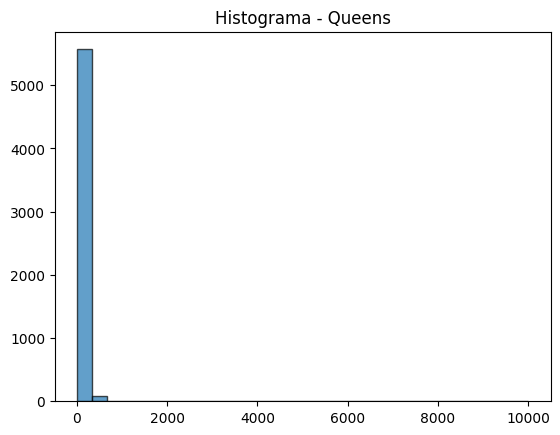

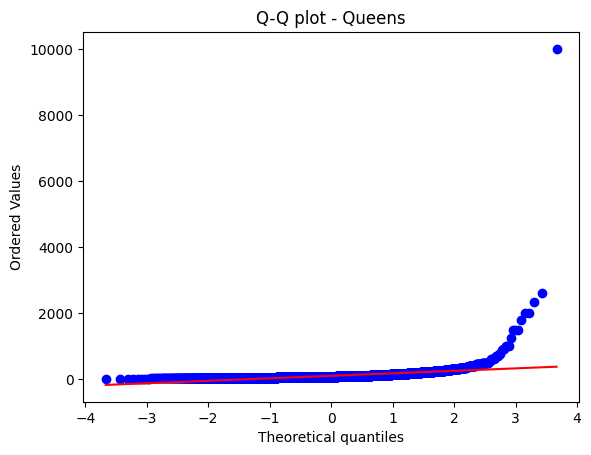

Queens - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.



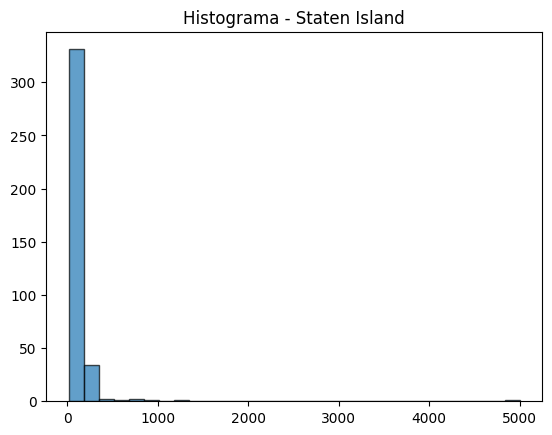

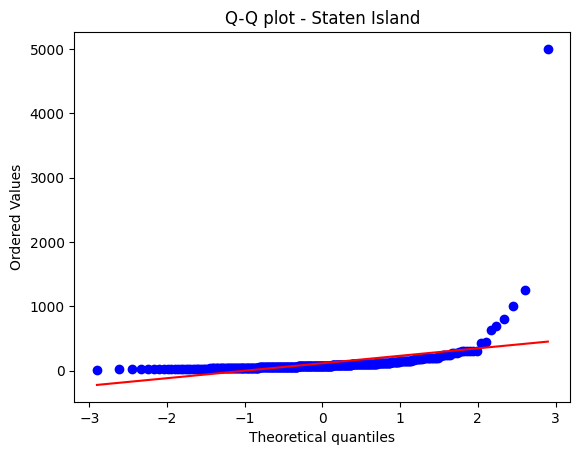

Staten Island - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.



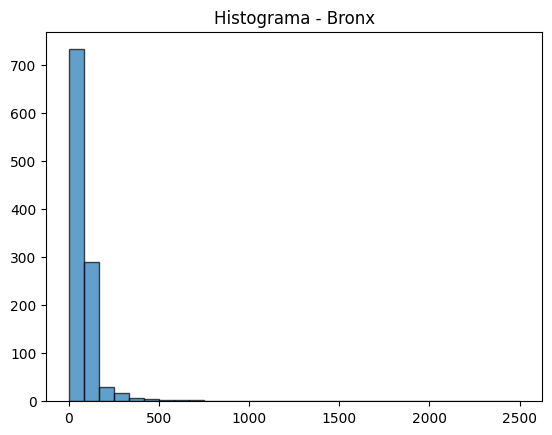

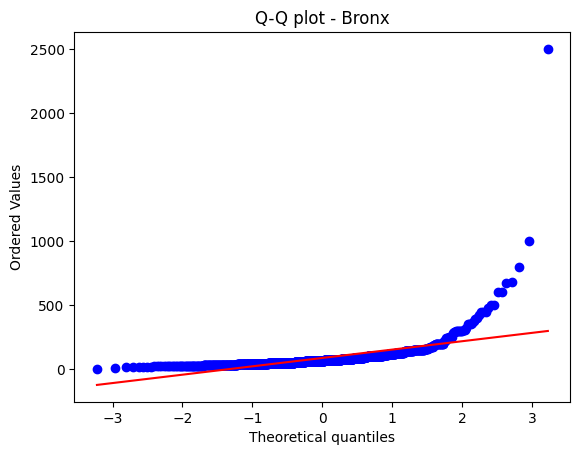

Bronx - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.



In [232]:
# Histograma e Q-Q plot para cada grupo do bairro
bairro_groups = df['bairro_group'].unique()
for group in bairro_groups:
    dados = df['price'][df['bairro_group'] == group]

    # Histograma
    plt.hist(dados, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Histograma - {group}')
    plt.show()
    
    # Q-Q plot
    stats.probplot(dados, dist="norm", plot=plt)
    plt.title(f'Q-Q plot - {group}')
    plt.show()
    
    # Testes de normalidade
    shapiro_test = stats.shapiro(dados)
    ks_test = stats.kstest(dados, 'norm')
    ad_test = stats.anderson(dados, dist='norm')
    
    print(f"{group} - Resultados dos Testes de Normalidade:")
    print(interpretar_normalidade(shapiro_test, ks_test, ad_test))

Como nenhum dos grupos segue uma distribuição normal, o teste mais apropriado para comparar as médias será o teste de Kruskal-Wallis, que é um teste não paramétrico e não exige que os dados sigam uma distribuição normal. Ele verifica se há diferenças significativas entre as distribuições de mais de dois grupos independentes.

In [233]:
# Realizando o teste de Kruskal-Wallis
statistic, p_value = kruskal(
    df['price'][df['bairro_group'] == 'Bronx'],
    df['price'][df['bairro_group'] == 'Brooklyn'],
    df['price'][df['bairro_group'] == 'Manhattan'],
    df['price'][df['bairro_group'] == 'Queens'],
    df['price'][df['bairro_group'] == 'Staten Island']
)

print(f"Estatística do teste: {statistic}")
print(f"Valor-p: {p_value}")

# A interpretação dos resultados depende do nível de significância escolhido alfa = 0.05
alpha = 0.05
if p_value < alpha:
    print("Rejeitar a hipótese nula - Existem diferenças significativas entre os grupos.")
else:
    print("Não rejeitar a hipótese nula - Não há diferenças significativas entre os grupos.")


Estatística do teste: 7027.45111221539
Valor-p: 0.0
Rejeitar a hipótese nula - Existem diferenças significativas entre os grupos.


Como o valor-p é menos que o nivel de significancia escolhido de 0.05, logo o resultado indica que há uma diferença significativa entre as médias dos preços dos imóveis por cidade. Ou seja, o preço médio varia de acordo com o bairro. Isso pode ter implicações para o mercado imobiliário, a demanda dos consumidores, a oferta dos vendedores, etc.

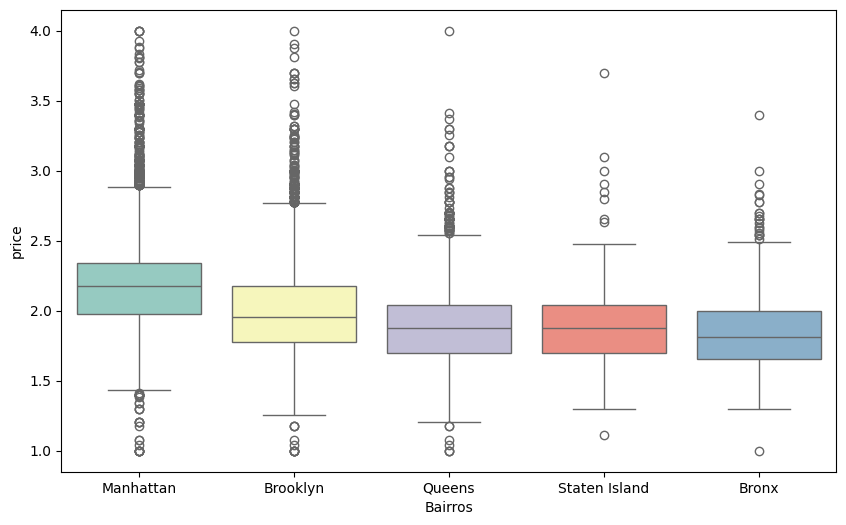

In [234]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
bairros = df.groupby('bairro_group').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
bairros = bairros['bairro_group']

# Criar uma figura com tamanho 10x6
plt.figure(figsize = (10,6))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='bairro_group', y ='price', data = log, order = bairros, palette = sns.color_palette("Set3", 5))

# Definir o rótulo do eixo x como 'Bairros'
ax.set_xlabel('Bairros')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

A partir desses boxplots, podemos concluir que:
* Manhattan tem uma variação de preço significativamente maior e preços mais altos em comparação com os outros bairros. 
* Brooklyn e Queens têm uma variação de preço semelhante, mas Brooklyn tem preços ligeiramente mais altos. 
* Staten Island e Bronx têm a menor variação de preço e os preços mais baixos.

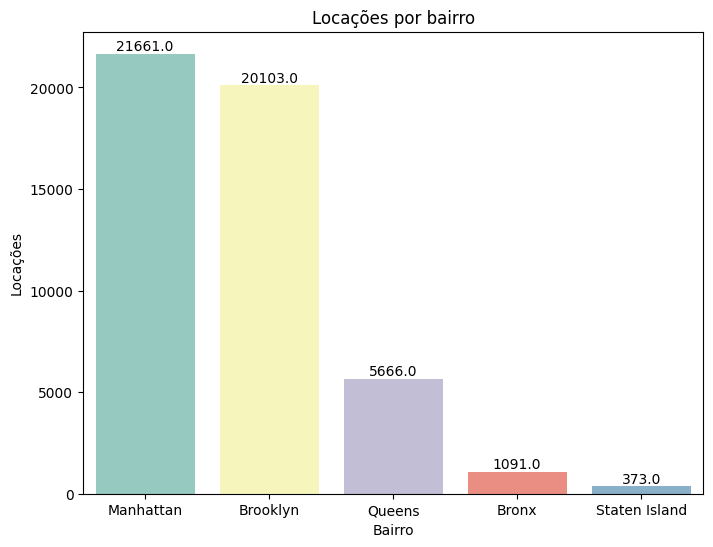

In [235]:
# Criar uma figura com tamanho 8x6
plt.figure(figsize=(8,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='bairro_group', data=df, order= df['bairro_group'].value_counts().index, palette=sns.color_palette("Set3", 5))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Bairro'
ax.set_xlabel('Bairro')

# Definir o rótulo do eixo y como 'Locações'
ax.set_ylabel('Locações')

# Definir o título do gráfico como 'Locações por bairro'
ax.set_title('Locações por bairro')

# Mostrar o gráfico
plt.show()

Como vimos na tabela anterior, a quantidade de locações nos bairros de Manhattan e Brooklyn estão muito acima dos demais bairros.

Conclusões finais:
* Manhattan é o bairro mais desejado e disputado de imóveis em Nova York, mas também o mais caro e instável. Os imóveis nesse bairro podem ter preços exorbitantes ou muito baixos, dependendo da oferta e da procura.
* Brooklyn e Queens são os bairros mais equilibrados e diversificados em termos de preços e tipos de imóveis em Nova York. Eles oferecem opções mais acessíveis e variadas do que Manhattan, mas também têm áreas mais valorizadas e outras menos. Eles também têm uma maior oferta e demanda de imóveis do que os outros bairros.
* Staten Island e Bronx são os bairros mais baratos e isolados em termos de preços e tipos de imóveis em Nova York. Eles têm pouca oferta e demanda de imóveis, e os preços são mais estáveis e baixos do que nos outros bairros. Eles podem ser uma boa opção para quem busca tranquilidade e economia, mas também podem ter menos infraestrutura e serviços.

## Nome

In [236]:
df.nome.value_counts()

nome
Hillside Hotel                                       18
Home away from home                                  17
New york Multi-unit building                         16
Brooklyn Apartment                                   12
Loft Suite @ The Box House Hotel                     11
                                                     ..
Charming one bedroom - newly renovated rowhouse       1
Affordable room in Bushwick/East Williamsburg         1
Sunny Studio at Historical Neighborhood               1
43rd St. Time Square-cozy single bed                  1
Trendy duplex in the very heart of Hell's Kitchen     1
Name: count, Length: 47904, dtype: int64

In [237]:
# Agrupar o dataframe por bairro_group e calcular a média da coluna valor
data_grouped = df.groupby('bairro_group')['price'].mean()

# Ordenar o dataframe em ordem decrescente de valor e selecionar os cinco primeiros grupos
data_grouped = data_grouped.sort_values(ascending=False).head(5)

In [238]:
# Criar uma lista vazia para armazenar os padrões
padroes = []

# Iterar sobre os cinco bairros selecionados
for bairro in data_grouped.index:
    # Filtrar o dataframe original para obter apenas os locais que pertencem ao bairro atual
    data_filtered = df[df['bairro_group'] == bairro]
    
    # Ordenar o dataframe filtrado em ordem decrescente de valor e selecionar os dez primeiros locais
    data_filtered = data_filtered.sort_values(by='price', ascending=False).head(10)
    
    # Converter a coluna nome em uma lista de strings
    nomes = data_filtered['nome'].tolist()
    
    # Criar a expressão regular para capturar palavras que comecem com uma letra maiúscula e tenham pelo menos três letras
    regex = r'\b[A-Z]\w{2,}\b'
    
    # Iterar sobre os nomes da lista nomes
    for nome in nomes:
        # Encontrar todas as ocorrências da expressão regular no nome atual
        palavras = re.findall(regex, nome)
        
        # Iterar sobre as palavras da lista palavras
        for palavra in palavras:
            # Verificar se a palavra atual já está na lista padroes
            if palavra not in padroes:
                # Adicionar a palavra à lista padroes
                padroes.append(palavra)

# Imprimir a lista padroes
print(padroes)

['Lincoln', 'Center', 'Spanish', 'Harlem', 'Apt', 'Quiet', 'Clean', 'Lit', 'LES', 'Chinatown', 'The', 'Heart', 'NYC', 'Manhattans', 'Lower', 'East', 'Side', 'Beautiful', 'Spacious', 'TriBeCa', 'Soho', 'Townhouse', 'Hidden', 'Airbnb', 'Luxury', 'MotorYacht', 'Hudson', 'Apartment', 'New', 'York', 'Hell', 'Kitchens', 'Manhattan', 'Film', 'Location', 'Gem', 'Flatbush', 'SUPER', 'BOWL', 'Brooklyn', 'Duplex', 'Fulton', 'NearWilliamsburg', 'Broadway', 'Northside', 'Williamsburg', 'Stunner', 'Photography', 'Victorian', 'Central', 'Hall', 'Colonial', 'Free', 'Parking', 'Bus', 'EXP', 'Stunning', 'Views', 'Harbor', 'Beach', 'House', 'Retreat', 'Wedding', 'Staten', 'Island', 'Resort', 'Amazing', 'FairPlay', 'BNB', 'Marathon', 'Furnished', 'Astoria', 'Majestic', 'Mansion', 'LifeStyle', 'Gorgeous', 'Bedroom', 'Room', 'Mins', 'Suite', 'Residence', 'Magnificent', 'Lakeview', 'Home', 'Kissena', 'Park', 'Oceanfront', 'Rockaway', 'December', 'Artist', 'LIC', 'Comfort', 'HOUR', 'YACHT', 'TOUR', 'Secret', 

In [239]:
# Criar a coluna padrao
df['padrao'] = df['nome'].str.extract(r'\b([A-Z]\w{2,})\b')

# Agrupar o dataframe por padrao e calcular a média da coluna price
data_grouped = df.groupby('padrao')['price'].mean()

# Ordenar o dataframe em ordem decrescente de price e selecionar os dez primeiros grupos
data_grouped = data_grouped.sort_values(ascending=False).head(10)

In [240]:
# Criar uma lista com os nomes dos padrões e outra lista com os preços médios
padroes = data_grouped.index.tolist()

# Acessar o valor da série usando o índice (padrão)
precos = data_grouped[padroes].tolist()

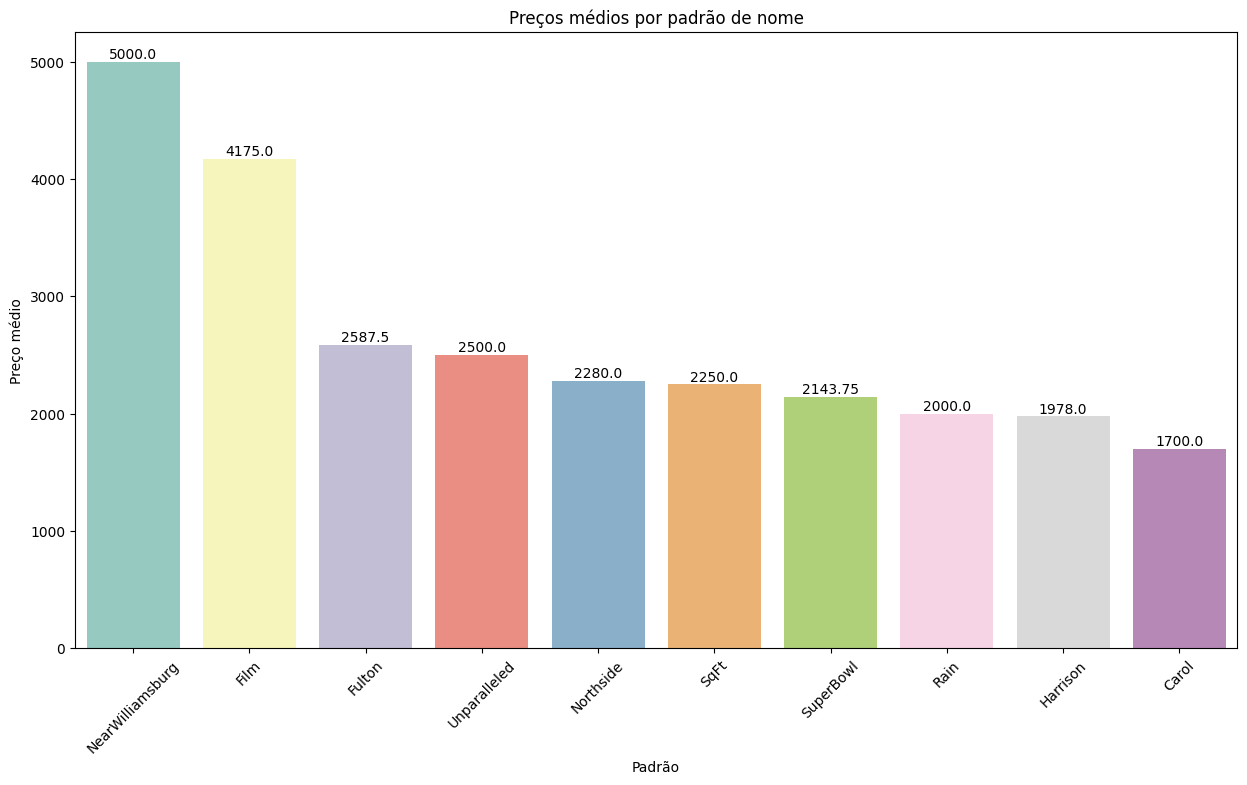

In [241]:
# Criar uma figura com tamanho 8x6
plt.figure(figsize=(15,8))

# Criar um gráfico de barras usando seaborn
ax = sns.barplot(x=padroes, y=precos, palette=sns.color_palette("Set3", 10))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Padrão'
ax.set_xlabel('Padrão')

# Definir o rótulo do eixo y como 'Preço médio'
ax.set_ylabel('Preço médio')

# Definir o título do gráfico como 'Preços médios por padrão de nome'
ax.set_title('Preços médios por padrão de nome')

# Rotacionar os rótulos do eixo x em 45 graus
plt.xticks(rotation=45)

# Mostrar o gráfico
plt.show()

Algumas conslusões:

* O padrão de nome que tem o maior preço médio é “Nearwillamsburg”, com 5000.0. Esse padrão pode indicar que se trata de um nome incomum, exótico ou de origem estrangeira, que pode atrair a atenção dos clientes ou sugerir uma qualidade superior.
* O padrão de nome que tem o menor preço médio é “Carol”, com 1700.0. Esse padrão pode indicar que se trata de um nome simples, curto ou de origem comum, que pode passar uma impressão de simplicidade ou baixa qualidade.
* Os padrões de nome que têm preços médios mais altos tendem a ter nomes mais curtos, simples ou genéricos, como “Rain”, “Fulton”, “Unparalleled”, “Northside”, “SqFt” e "Harrison". Esses padrões podem indicar que os locais são mais personalizados, diferenciados ou inovadores, que podem gerar mais valor ou interesse nos clientes.

## Room Type

In [242]:
df.room_type.value_counts()

room_type
Entire home/apt    25409
Private room       22325
Shared room         1160
Name: count, dtype: int64

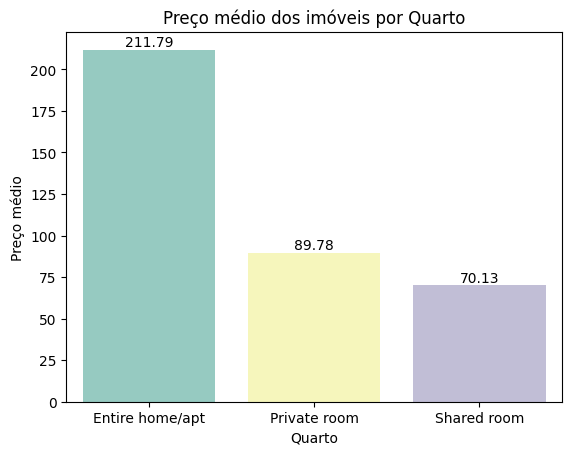

In [243]:
# Agrupar o dataframe por Quarto e calcular a média do preço
df_grouped = df.groupby('room_type')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Quarto')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio dos imóveis por Quarto')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, 
                         ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:
* O preço médio dos imóveis varia significativamente dependendo do tipo de quarto. O preço médio é mais alto para um apartamento/casa inteira, seguido por um quarto privado e, finalmente, um quarto compartilhado.
* A diferença de preço entre um apartamento/casa inteira e um quarto privado é de cerca de 122 dolares, o que representa uma variação de aproximadamente 136%. Isso indica que há uma grande demanda por espaços maiores e mais privados na área.
* A diferença de preço entre um quarto privado e um quarto compartilhado é de cerca de 20 dolares, o que representa uma variação de cerca de 22%. Isso sugere que há uma oferta limitada de quartos compartilhados na área, ou que as pessoas preferem pagar um pouco mais por um quarto privado.

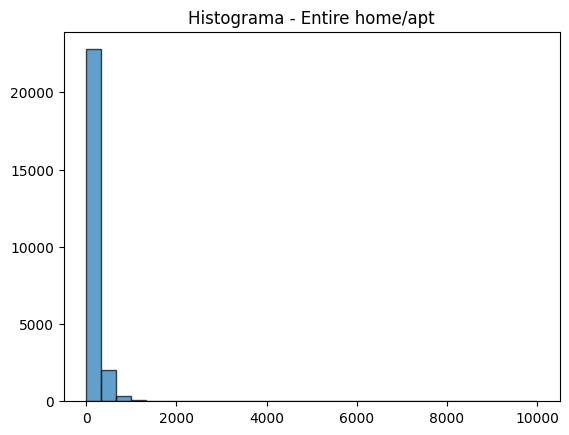

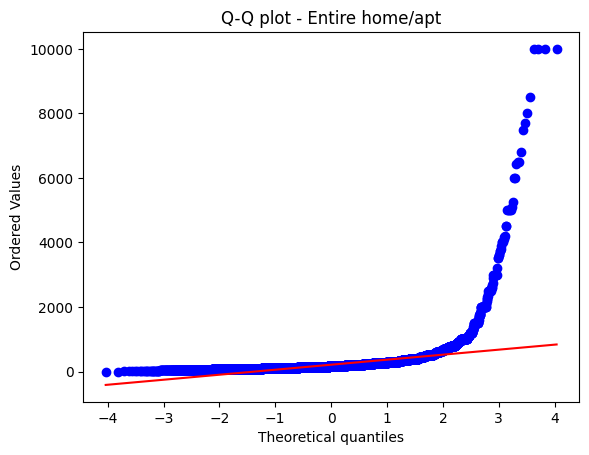

Entire home/apt - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.



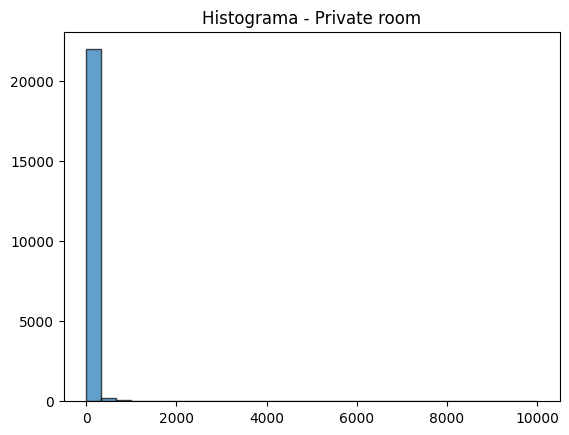

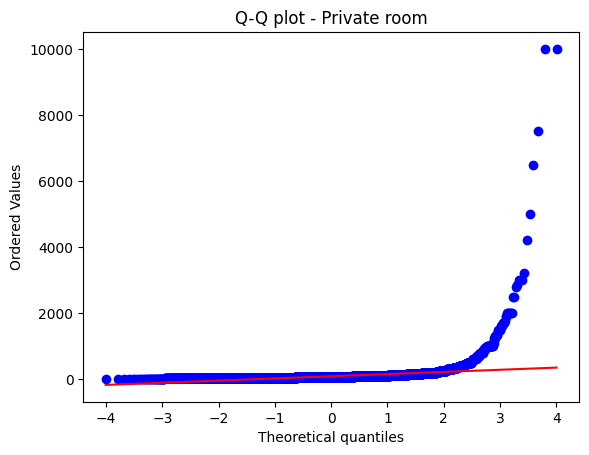

Private room - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.



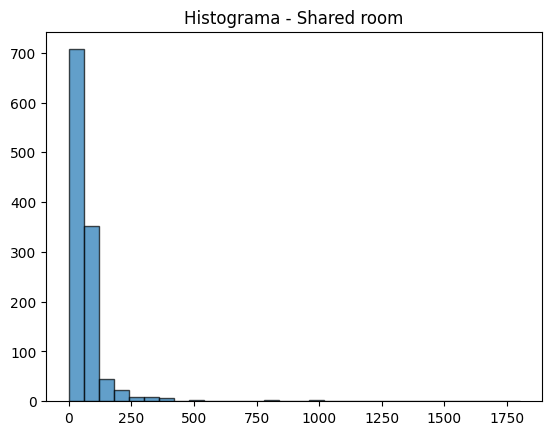

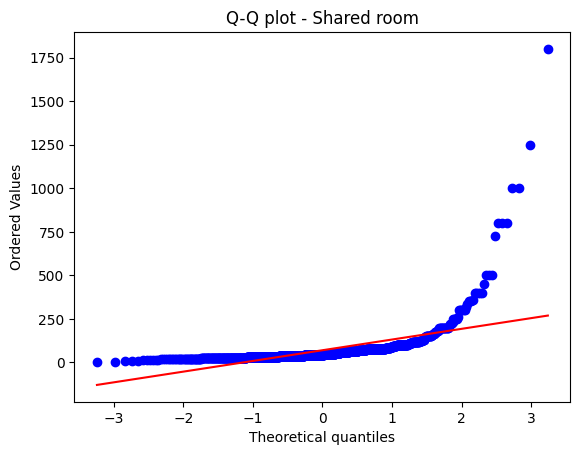

Shared room - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.



In [244]:
# Histograma e Q-Q plot para cada grupo do quarto
room_groups = df['room_type'].unique()
for group in room_groups:
    dados = df['price'][df['room_type'] == group]

    # Histograma
    plt.hist(dados, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Histograma - {group}')
    plt.show()
    
    # Q-Q plot
    stats.probplot(dados, dist="norm", plot=plt)
    plt.title(f'Q-Q plot - {group}')
    plt.show()
    
    # Testes de normalidade
    shapiro_test = stats.shapiro(dados)
    ks_test = stats.kstest(dados, 'norm')
    ad_test = stats.anderson(dados, dist='norm')
    
    print(f"{group} - Resultados dos Testes de Normalidade:")
    print(interpretar_normalidade(shapiro_test, ks_test, ad_test))

Como nenhum dos grupos segue uma distribuição normal, optamos por utilizar o teste de Kruskal-Wallis, que é mais adequado para comparar grupos quando os dados não atendem ao critério de normalidade.

In [245]:
# Agrupar o dataframe por Quarto e calcular a média do preço
df_grouped = df.groupby('room_type')['price'].mean()

# Selecionar as séries de preços por Quarto
entire_home = df['price'][df['room_type'] == 'Entire home/apt']
private_room = df['price'][df['room_type'] == 'Private room']
shared_room = df['price'][df['room_type'] == 'Shared room']

# Realizando Kruskal
f_statistic, p_value = kruskal(entire_home, private_room, shared_room)

print(f"Estatística F: {f_statistic}")
print(f"Valor-p: {p_value}")

# A interpretação dos resultados depende do nível de significância escolhido alfa = 0.05
alpha = 0.05
if p_value < alpha:
    print("Rejeitar a hipótese nula - As medianas não são iguais.")
else:
    print("Não rejeitar a hipótese nula - Não há diferença significativa entre as medianas.")

Estatística F: 22418.72176007445
Valor-p: 0.0
Rejeitar a hipótese nula - As medianas não são iguais.


Ao realizar o teste de Kruskal para comparar as medianas dos preços dos imóveis por Quarto, obtevemos um valor-p muito baixo, o que significa que podemos rejeitar a hipótese nula de que as medianas são iguais. Isso implica que há uma diferença estatisticamente significativa entre as medianas dos preços dos imóveis por Quarto.

Podemos concluir que o tipo de Quarto influencia o preço do imóvel, e que os imóveis do tipo Entire home/apt são, em média, mais caros do que os do tipo Private room ou Shared room.

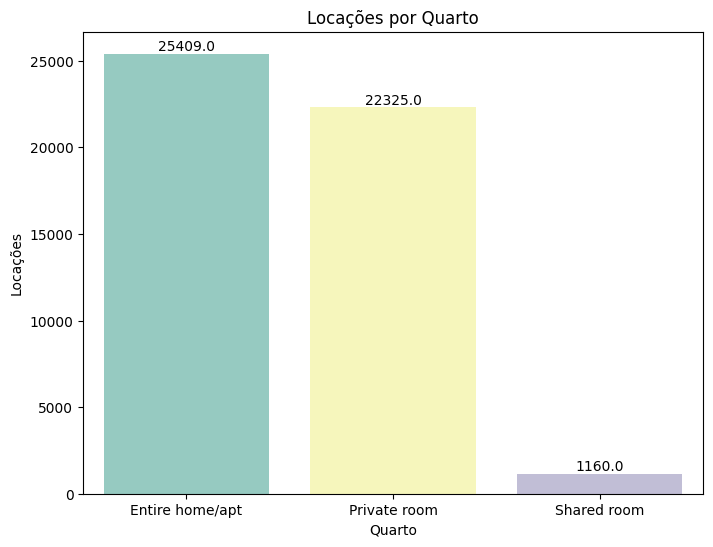

In [246]:
# Criar uma figura com tamanho 8x6
plt.figure(figsize=(8,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='room_type', data=df, order= df['room_type'].value_counts().index, palette=sns.color_palette("Set3"))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Tipo de quarto'
ax.set_xlabel('Quarto')

# Definir o rótulo do eixo y como 'Locações'
ax.set_ylabel('Locações')

# Definir o título do gráfico como 'Locações por bairro'
ax.set_title('Locações por Quarto')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* As locações de casas/apartamentos inteiros são mais populares, seguidas por quartos privados e, por último, quartos compartilhados.
* A demanda por quartos compartilhados é muito baixa, representando apenas cerca de 4% do total de locações.
* A diferença entre as locações de casas/apartamentos inteiros e quartos privados é pequena, indicando que ambos os tipos de quarto têm uma demanda semelhante.
* O gráfico pode sugerir que as pessoas preferem ter mais privacidade e conforto ao alugar um espaço, ou que há uma escassez de opções de quartos compartilhados na área.

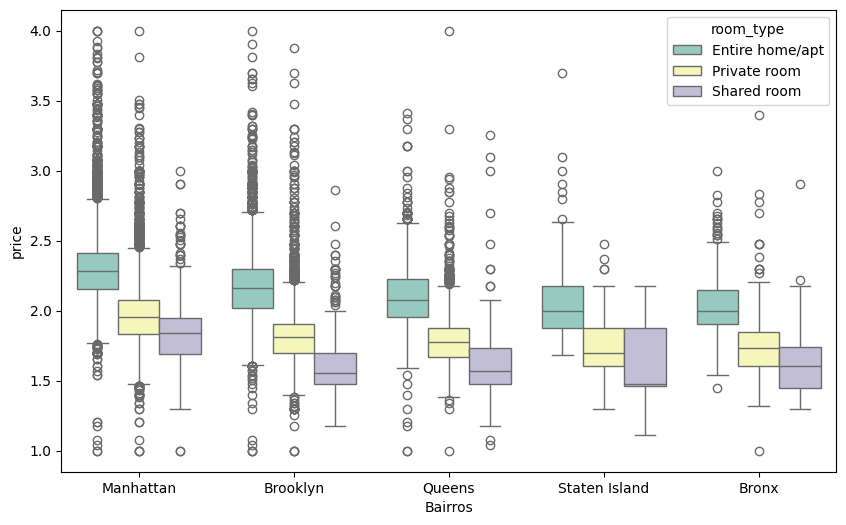

In [247]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
bairros = df.groupby('bairro_group').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
bairros = bairros['bairro_group']

# Criar uma figura com tamanho 10x6
plt.figure(figsize = (10,6))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='bairro_group', y ='price', data = log, 
                 hue = 'room_type',order = bairros, 
                 palette = sns.color_palette("Set3", 5))

# Definir o rótulo do eixo x como 'Bairros'
ax.set_xlabel('Bairros')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

Algumas conclusões:
* O preço dos quartos varia consideravelmente dentro de cada bairro e tipo de quarto. Manhattan tem os preços mais altos, especialmente para casas/apartamentos inteiros. Os quartos compartilhados geralmente são mais baratos em todos os bairros.
* Brooklyn e Queens têm uma distribuição semelhante dos preços dos quartos, mas Brooklyn tem mais outliers nos preços mais altos.
* Staten Island e Bronx têm menos dados representados no gráfico, indicando menores listagens disponíveis ou dados coletados.

Conclusões finais:

* Alugar um apartamento/casa inteira em Nova York é uma opção cara e competitiva, que requer uma renda alta e uma boa verificação de crédito. Muitas pessoas optam por essa opção por questões de privacidade, conforto e status.
* Alugar um quarto privado em Nova York é uma opção mais acessível e flexível, que permite economizar dinheiro e conviver com outras pessoas. Muitas pessoas escolhem essa opção por questões de praticidade, conveniência e sociabilidade.
* Alugar um quarto compartilhado em Nova York é uma opção rara e barata, que exige uma adaptação maior e uma tolerância maior. Poucas pessoas preferem essa opção por questões de necessidade, oportunidade ou experiência.
* Os bairros de Nova York têm características diferentes que influenciam nos preços e na disponibilidade dos quartos. Manhattan é o bairro mais caro e disputado, Brooklyn e Queens são os bairros mais diversificados e equilibrados, e Staten Island e Bronx são os bairros mais baratos e isolados.

## Minimo Noites

In [248]:
# Top 10 noites minimos
df.minimo_noites.value_counts().head(10)

minimo_noites
1     12719
2     11696
3      7999
30     3760
4      3303
5      3034
7      2058
6       752
14      562
10      483
Name: count, dtype: int64

In [249]:
# Procentagem top 10 em relação ao total
round((sum(df.minimo_noites.value_counts().head(10))/sum(df.minimo_noites.value_counts()))*100, 2)

94.83

Analisaremos apenas as 10 quantidades minimas de noites, com maior número de aluguéis, para facilitar a visualização, pois o top 10 representa 94,83% dos dados.

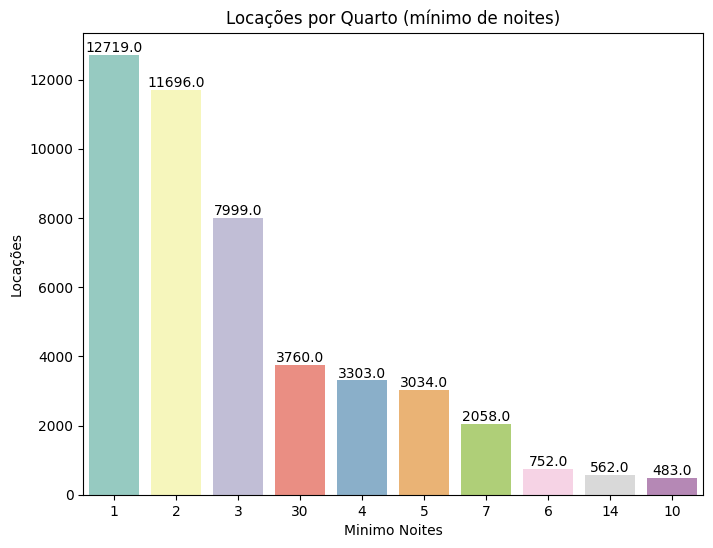

In [250]:
# Contar a frequência de cada variável "minimo_noites"
df_minimo_noites_count = df['minimo_noites'].value_counts()

# Ordenar as variáveis por frequência decrescente
df_minimo_noites_count = df_minimo_noites_count.sort_values(ascending=False)

# Definir o número de variáveis a serem exibidas
numero_variaveis = 10

# Selecionar as "numero_variaveis" variáveis mais frequentes
top_minimo_noites = df_minimo_noites_count.index[:numero_variaveis]

# Criar uma figura com tamanho 8x6
plt.figure(figsize=(8,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='minimo_noites', data=df[df['minimo_noites'].isin(top_minimo_noites)], order=top_minimo_noites, palette=sns.color_palette("Set3"))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
        plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                ax.patches[i].get_width() / 2, 
                                                ax.patches[i].get_height()), 
                                                size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Minimo Noites'
ax.set_xlabel('Minimo Noites')

# Definir o rótulo do eixo y como 'Locações'
ax.set_ylabel('Locações')

# Definir o título do gráfico como 'Locações por Quarto'
ax.set_title('Locações por Quarto (mínimo de noites)')

# Mostrar o gráfico
plt.show()


Algumas conclusões:

* A maioria dos quartos tem um mínimo de 1 ou 2 noites, o que indica uma alta demanda por estadias curtas.
* Há uma queda acentuada no número de locações à medida que o mínimo de noites aumenta, o que sugere uma baixa preferência por estadias longas.
* Os valores mínimos de noites mais altos, como 10 e 14, podem corresponder a quartos especiais ou sazonais, que têm menos oferta e demanda.
* Valores como 30 noites mínimas apresentam um número de locações relativamente alto, o que pode ser explicado por alguns clientes que preferem estadias mensais.

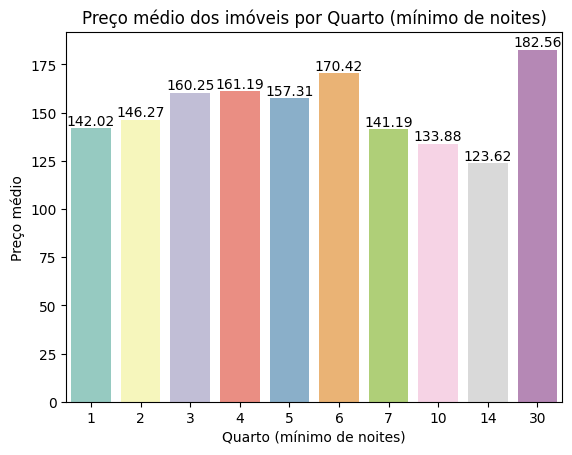

In [251]:
# Contar a frequência de cada variável "minimo_noites"
df_minimo_noites_count = df['minimo_noites'].value_counts()

# Ordenar as variáveis por frequência decrescente
df_minimo_noites_count = df_minimo_noites_count.sort_values(ascending=False)

# Definir o número de variáveis a serem exibidas
numero_variaveis = 10

# Selecionar as "numero_variaveis" variáveis mais frequentes
top_minimo_noites = df_minimo_noites_count.index[:numero_variaveis]

# Agrupar o dataframe pelas variáveis "minimo_noites" mais frequentes e calcular a média do preço
df_grouped = df[df['minimo_noites'].isin(top_minimo_noites)].groupby('minimo_noites')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Quarto (mínimo de noites)')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio dos imóveis por Quarto (mínimo de noites)')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, 
                         ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* O preço médio dos imóveis aumenta com o aumento do número mínimo de noites requeridas para a estadia. O preço é mais baixo para estadias de 7, 10 e 14 noites, e mais alto para estadias de 30 noites.
* Há uma clara queda no preço médio para estadias quinzenais.
* Descontos para estadias longas: Proprietários podem oferecer descontos para incentivar estadias quinzenais, o que garante renda por um período mais extenso e diminui a rotatividade de hóspedes.
* Custos fixos: Os custos fixos de manutenção do quarto, como limpeza e preparação, são diluídos em estadias quinzenais, o que permite aos proprietários oferecer preços mais baixos.
* Demanda: A demanda por quartos pode ser maior para estadias curtas, o que justifica preços mais altos.

In [252]:
# Agrupar o dataframe pelas variáveis "minimo_noites" mais frequentes e calcular a média do preço
df_grouped = df[df['minimo_noites'].isin(top_minimo_noites)].groupby('minimo_noites')['price'].mean()

# Selecionar as séries de preços por Quarto (mínimo de noites)
one_night = df['price'][df['minimo_noites'] == 1]
two_nights = df['price'][df['minimo_noites'] == 2]
three_nights = df['price'][df['minimo_noites'] == 3]
four_nights = df['price'][df['minimo_noites'] == 4]
five_nights = df['price'][df['minimo_noites'] == 5]
six_nights = df['price'][df['minimo_noites'] == 6]
seven_nights = df['price'][df['minimo_noites'] == 7]
ten_nights = df['price'][df['minimo_noites'] == 10]
fourteen_nights = df['price'][df['minimo_noites'] == 14]
thirty_nights = df['price'][df['minimo_noites'] == 30]

# Realizando ANOVA
f_statistic, p_value = f_oneway(one_night, two_nights, three_nights, four_nights, five_nights, six_nights, seven_nights, ten_nights, fourteen_nights, thirty_nights)

print(f"Estatística F: {f_statistic}")
print(f"Valor-p: {p_value}")

# A interpretação dos resultados depende do nível de significância escolhido alfa e.g., 0.05
alpha = 0.05
if p_value < alpha:
    print("Rejeitar a hipótese nula - As médias não são iguais.")
else:
    print("Não rejeitar a hipótese nula - Não há diferença significativa entre as médias.")

Estatística F: 15.267064354906521
Valor-p: 3.8822009045460645e-25
Rejeitar a hipótese nula - As médias não são iguais.


Ao realizar o teste ANOVA para comparar as médias dos preços dos imóveis por Quarto (mínimo de noites), obtevemos um valor-p muito baixo, o que significa que podemos rejeitar a hipótese nula de que as médias são iguais. Isso implica que há uma diferença estatisticamente significativa entre as médias dos preços dos imóveis por Quarto (mínimo de noites).

Podemos concluir que o número mínimo de noites influencia o preço do imóvel, e que os imóveis que exigem mais noites são, em média, mais caros do que os que exigem menos noites. Com excessão as estadias de 7 a 14 noites.

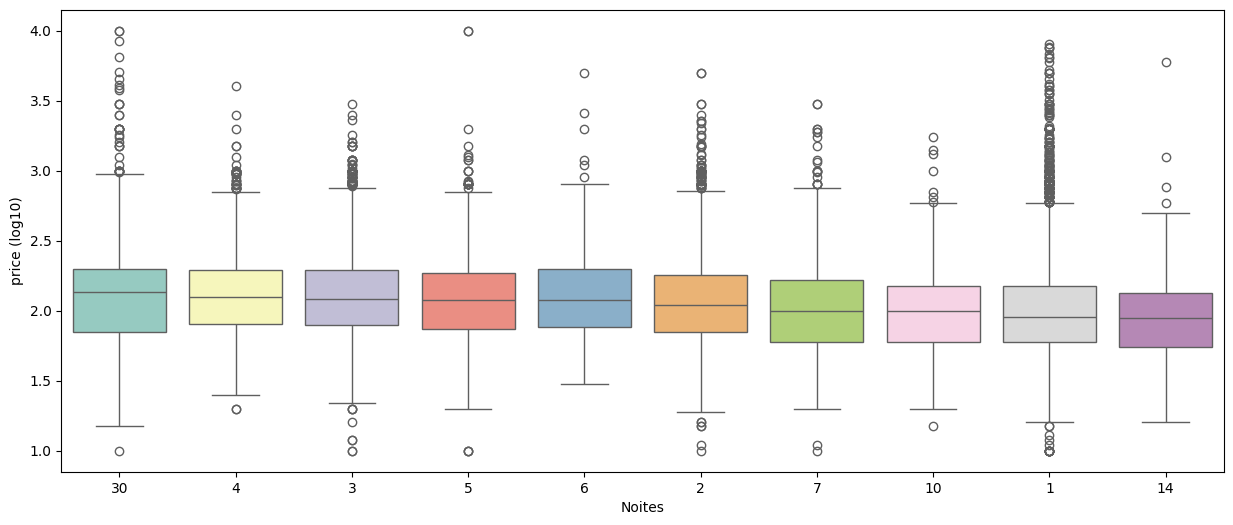

In [253]:
# Contar a frequência de cada variável "minimo_noites"
df_minimo_noites_count = df['minimo_noites'].value_counts()

# Ordenar as variáveis por frequência decrescente
df_minimo_noites_count = df_minimo_noites_count.sort_values(ascending=False)

# Definir o número de variáveis a serem exibidas
numero_variaveis = 10

# Selecionar as "numero_variaveis" variáveis mais frequentes
top_minimo_noites = df_minimo_noites_count.index[:numero_variaveis]

# Agrupar os dados por noites e calcular a mediana do preço
noites = df[df['minimo_noites'].isin(top_minimo_noites)].groupby('minimo_noites').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
noites = noites['minimo_noites']

# Criar uma figura com tamanho 15x6
plt.figure(figsize = (15,6))

# Fazer uma cópia dos dados originais
log = df[df['minimo_noites'].isin(top_minimo_noites)].copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='minimo_noites', y ='price', data = log, 
                 order = noites, 
                 palette = sns.color_palette("Set3", 10))

# Definir o rótulo do eixo x como 'Noites'
ax.set_xlabel('Noites')

# Definir o rótulo do eixo y como 'price (log10)'
ax.set_ylabel('price (log10)')

# Mostrar o gráfico
plt.show()

* Há muitos outliers em cada categoria do número mínimo de noites; esses são pontos que caem bem fora da faixa interquartil. Isso pode indicar que há alguns imóveis muito caros ou muito baratos que não seguem uma tendência.
* No geral, o gráfico mostra que o preço por noite aumenta com o número mínimo de noites. Há uma grande variabilidade nos preços por noite, especialmente para estadia minima de 30 noites. Há também alguns valores discrepantes nos gráficos, que representam preços por noite muito mais altos ou mais baixos do que a maioria dos outros valores.

Conclusões finais:

* Os gráficos mostram que há uma relação entre o número mínimo de noites e o preço por noite dos imóveis. Essa relação pode ser influenciada por fatores como oferta, demanda, custos fixos e descontos.
* Também mostram que há uma grande diversidade de preços por noite para cada categoria do número mínimo de noites. Isso pode refletir as diferentes características, localizações e qualidades dos imóveis disponíveis.
* Os gráficos podem ser úteis para clientes que querem comparar os preços dos imóveis de acordo com o número mínimo de noites que pretendem ficar. O gráfico também pode ser útil para proprietários que querem ajustar os seus preços de acordo com o número mínimo de noites que oferecem.

In [254]:
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,padrao
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,Skylit
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,THE
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,Cozy
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,Entire
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,Large


## Número de Reviews

In [255]:
df.numero_de_reviews.nunique()

394

In [256]:
df.numero_de_reviews.value_counts().head()

numero_de_reviews
0    10052
1     5244
2     3465
3     2520
4     1994
Name: count, dtype: int64

Como a variável "classificacao_reviews" tem muitos valores distintos, vamos classificá-los em grupos:

* Classificamos como 1 os valores com 0 review.
* Classificamos como 2 os valores com 1, 2 ou 3 reviews.
* Classificamos como 3 os valores com 4, 5 ou 6 reviews.
* Classificamos como 4 os valores com 7, 8 ou 9 reviews.
* Classificamos como 5 os valores entre 10 e 15 reviews.
* Classificamos como 6 os valores entre 16 e 26 reviews.
* Classificamos como 7 os valores entre 27 e 40 reviews.
* Classificamos como 8 os valores entre 41 e 90 reviews.
* Classificamos como 9 os valores entre 91 e 160 reviews.
* Classificamos como 10 os demais valores.

In [257]:
# Definindo os intervalos e os rótulos das categorias
bins = [-1, 0, 3, 6, 9, 15, 26, 40, 90, 160, np.inf]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Criando uma nova coluna com a classificação dos valores em 10 categorias
df['classificacao_reviews'] = pd.cut(df['numero_de_reviews'], bins=bins, labels=labels)

# Mostrando o resultado
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,padrao,classificacao_reviews
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,Skylit,8
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,THE,1
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,Cozy,10
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,Entire,4
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,Large,8


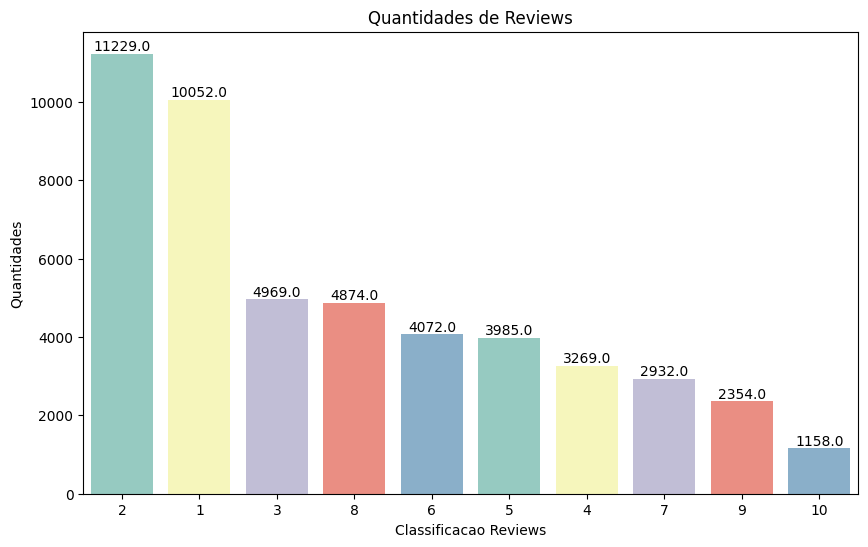

In [258]:
# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='classificacao_reviews', data=df, order= df['classificacao_reviews'].value_counts().index, palette=sns.color_palette("Set3", 5))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Classificacao Reviews'
ax.set_xlabel('Classificacao Reviews')

# Definir o rótulo do eixo y como 'Quantidades'
ax.set_ylabel('Quantidades')

# Definir o título do gráfico como 'Quantidades de Reviews'
ax.set_title('Quantidades de Reviews')

# Mostrar o gráfico
plt.show()

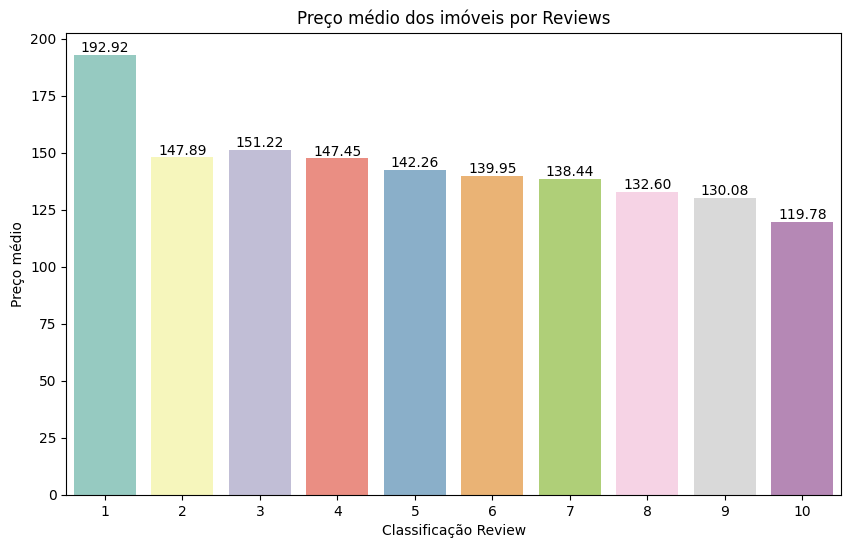

In [259]:
# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Agrupar o dataframe por review e calcular a média do preço
df_grouped = df.groupby('classificacao_reviews')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Classificação Review')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio dos imóveis por Reviews')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* Os imóveis com classificação de review do grupo 1, ou seja, sem review têm o preço médio mais alto, enquanto os imóveis com classificação de review do grupo 10, o grupo com a maior quantidade de reviews têm o preço médio mais baixo.
* O preço médio dos imóveis geralmente diminui à medida que a classificação de review aumenta, com algumas flutuações entre as classificações de 2 a 7.
* Isso pode sugerir que os imóveis com classificações de review mais baixas são mais caros porque são mais raros, mais luxuosos ou mais procurados. Por outro lado, os imóveis com classificações de review mais altas podem ser mais baratos porque são mais comuns, mais simples ou menos demandados.

In [260]:
review_groups = df['classificacao_reviews'].unique()
for group in review_groups:
    dados = df['price'][df['classificacao_reviews'] == group]
    
    # Testes de normalidade
    shapiro_test = stats.shapiro(dados)
    ks_test = stats.kstest(dados, 'norm')
    ad_test = stats.anderson(dados, dist='norm')
    
    print(f"{group} - Resultados dos Testes de Normalidade:")
    print(interpretar_normalidade(shapiro_test, ks_test, ad_test))

8 - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.

1 - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.

10 - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.

4 - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.

9 - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese

In [261]:
# Agrupar o dataframe por Reviews e calcular a média do preço
df_grouped = df.groupby('classificacao_reviews')['price'].mean()

# Selecionar as séries de preços por Reviews
one_star = df['price'][df['classificacao_reviews'] == 1]
two_stars = df['price'][df['classificacao_reviews'] == 2]
three_stars = df['price'][df['classificacao_reviews'] == 3]
four_stars = df['price'][df['classificacao_reviews'] == 4]
five_stars = df['price'][df['classificacao_reviews'] == 5]
six_stars = df['price'][df['classificacao_reviews'] == 6]
seven_stars = df['price'][df['classificacao_reviews'] == 7]
eight_stars = df['price'][df['classificacao_reviews'] == 8]
nine_stars = df['price'][df['classificacao_reviews'] == 9]
ten_stars = df['price'][df['classificacao_reviews'] == 10]

# Realizar ANOVA
f_statistic, p_value = kruskal(one_star, two_stars, three_stars, four_stars, five_stars, six_stars, seven_stars, eight_stars, nine_stars, ten_stars)

print(f"Estatística F: {f_statistic}")
print(f"Valor-p: {p_value}")

# A interpretação dos resultados depende do nível de significância escolhido alfa e.g., 0.05
alpha = 0.05
if p_value < alpha:
    print("Rejeitar a hipótese nula - As medianas não são iguais.")
else:
    print("Não rejeitar a hipótese nula - Não há diferença significativa entre as medianas.")

Estatística F: 270.86765465231883
Valor-p: 3.8772330731094264e-53
Rejeitar a hipótese nula - As medianas não são iguais.


Ao realizar o teste de Kruskal para comparar as medianas dos preços dos imóveis por Reviews, e obteve um valor-p muito baixo, o que significa que você pode rejeitar a hipótese nula de que as medianas são iguais. Isso implica que há uma diferença estatisticamente significativa entre as medianas dos preços dos imóveis por Reviews.

Uma possível conclusão que podemos tirar com esse resultado é que a classificação dos Reviews influencia o preço do imóvel, e que os imóveis com mais Reviews, em média, são mais baratos do que os com menos Reviews.

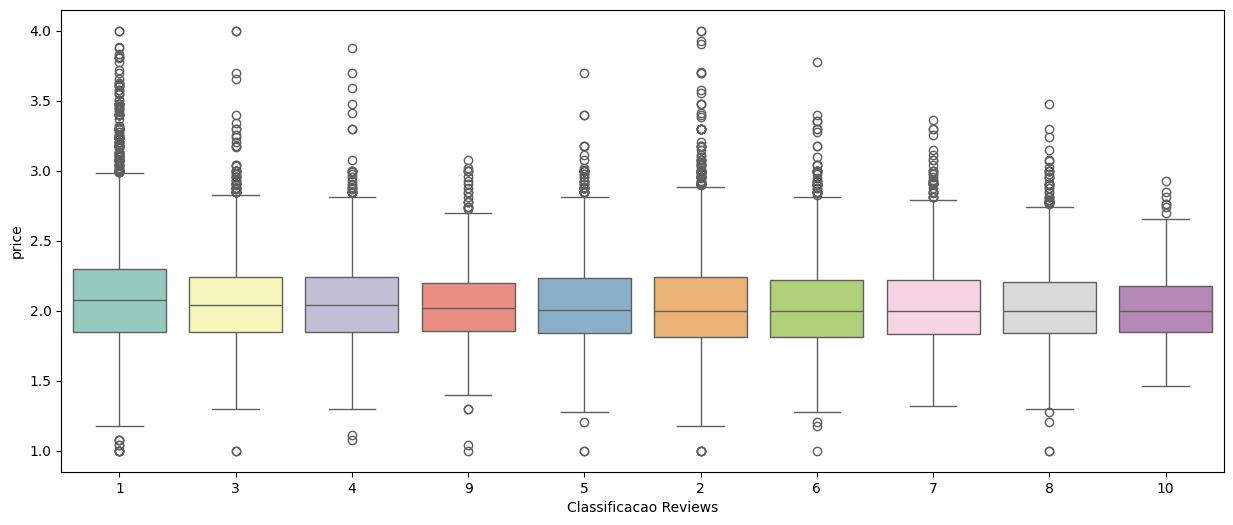

In [262]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
rev = df.groupby('classificacao_reviews').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
rev = rev['classificacao_reviews']

# Criar uma figura com tamanho 15x6
plt.figure(figsize = (15,6))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='classificacao_reviews', y ='price', data = log, order = rev, palette = sns.color_palette("Set3", 10))

# Definir o rótulo do eixo x como 'Classificacao Reviews'
ax.set_xlabel('Classificacao Reviews')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* Os imóveis com classificação de review de 1 têm uma maior variação de preços, com vários outliers indicando alguns imóveis muito mais caros.
* Os imóveis com classificação de review de 9 e 10 têm uma menor variação de preços e menos outliers, sugerindo mais consistência na precificação.
* Os imóveis com outras classificações de review (2, 3, 4, 5, 6, 7, 8) mostram uma variabilidade moderada de preços, mas não tão diversa quanto a classificação de review 1.
* Não há uma tendência clara que mostre que classificações de review mais altas ou mais baixas se correlacionam com preços mais altos ou mais baixos; há variabilidade em todas as classificações.

Conclusões finais:

* Os gráficos mostram que há uma relação inversa entre o preço médio dos imóveis e a classificação de review. Essa relação pode ser influenciada por fatores como oferta, demanda, qualidade e preferência dos usuários.
* Também mostram que há uma grande diversidade de preços dos imóveis para cada classificação de review. Isso pode refletir as diferentes características, localizações e qualidades dos imóveis disponíveis.

## Reviews Por Mês

In [263]:
# Usando fillna para substituir os valores NaN por 0
df['reviews_por_mes'] = df['reviews_por_mes'].fillna(0)

In [264]:
# Verificando valores minimos e máximos de reviews mensais
df.reviews_por_mes.min(), df.reviews_por_mes.max()

(np.float64(0.0), np.float64(58.5))

In [265]:
# Verificando a quantidade de cada Review
df.reviews_por_mes.value_counts().head()

reviews_por_mes
0.00    10052
0.02      919
0.05      893
1.00      893
0.03      804
Name: count, dtype: int64

Como a variável "reviews_por_mes" tem muitos valores distintos, vamos classificá-los em grupos:

* Classificamos como 1 os valores com 0 review.
* Classificamos como 2 os valores entre 0 e 0.25 reviews.
* Classificamos como 3 os valores entre 0.25 e 0.5 reviews.
* Classificamos como 4 os valores entre 0.5 e 1 reviews.
* Classificamos como 5 os valores entre 1 e 1.5 reviews.
* Classificamos como 6 os valores entre 1.5 e 2.5 reviews.
* Classificamos como 7 os valores entre 2.5 e 3.5 reviews.
* Classificamos como 8 os demais valores.

In [266]:
# Definindo os intervalos e os rótulos dos grupos
bins = [-1, 0, 0.25, 0.5, 1, 1.5, 2.5, 3.5, np.inf]
labels = [1, 2, 3, 4, 5, 6, 7, 8]

# Criando uma nova coluna com a classificação dos valores em 9 grupos
df['classificacao_reviews_por_mes'] = pd.cut(df['reviews_por_mes'], bins=bins, labels=labels)

# Mostrando o resultado
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,padrao,classificacao_reviews,classificacao_reviews_por_mes
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,Skylit,8,3
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365,THE,1,1
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,Cozy,10,8
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,Entire,4,2
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,Large,8,4


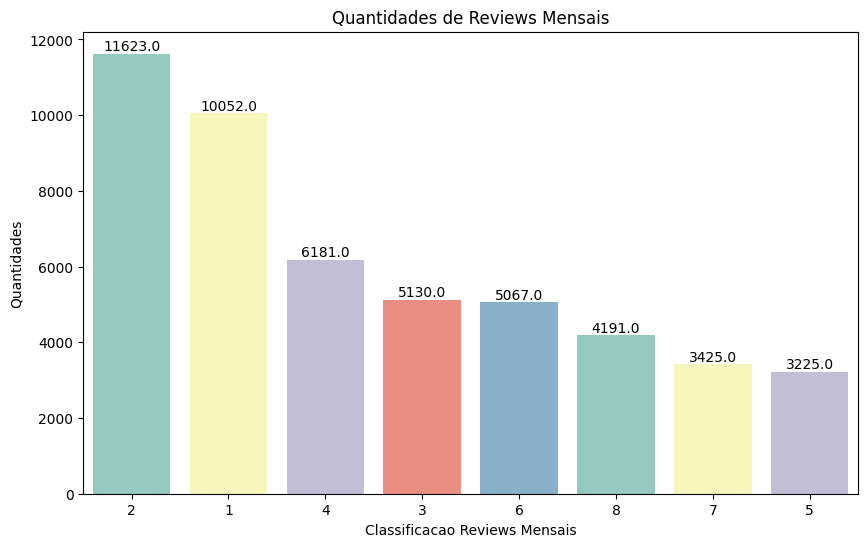

In [267]:
# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='classificacao_reviews_por_mes', data=df, order= df['classificacao_reviews_por_mes'].value_counts().index, palette=sns.color_palette("Set3", 5))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Classificacao Reviews Mensais'
ax.set_xlabel('Classificacao Reviews Mensais')

# Definir o rótulo do eixo y como 'Quantidades'
ax.set_ylabel('Quantidades')

# Definir o título do gráfico como 'Quantidades de Reviews'
ax.set_title('Quantidades de Reviews Mensais')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* A maioria dos reviews por mês se enquadra na categoria 2 (0 a 0.25 reviews) e na categoria 1 (0 review), com contagens de 11623 e 10052 respectivamente.
* As categorias 4 (0.5 a 1 reviews), 3 (0.25 a 0.5 reviews) e 6 (1.5 a 2.5) têm um número moderado de reviews mensais.
* As categorias com maiores contagens de reviews por mês, como as categorias 8, 7 e 5, têm significativamente menos instâncias.

Isso sugere que a maioria dos imóveis tem pouca ou nenhuma avaliação dos hóspedes, enquanto alguns têm avaliações muito frequentes. Talvez isso esteja relacionado à popularidade, à qualidade ou ao preço dos imóveis. 

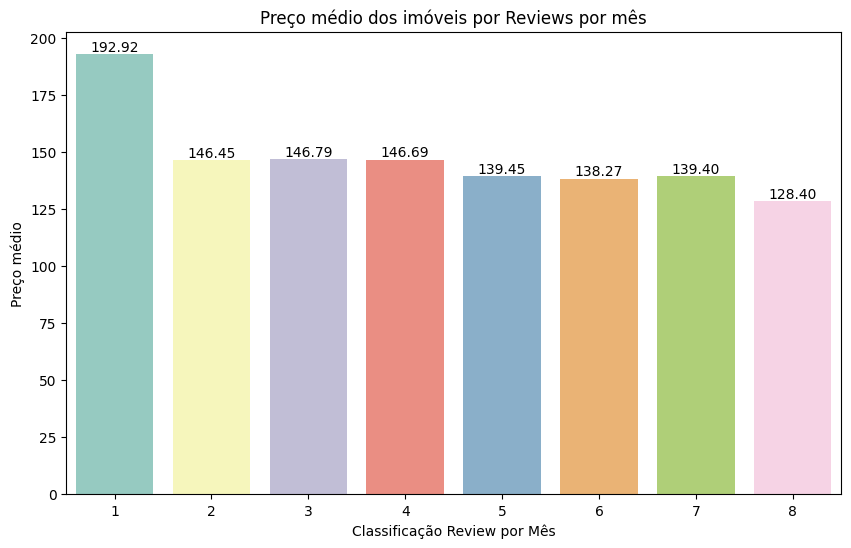

In [268]:
# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Agrupar o dataframe por review e calcular a média do preço
df_grouped = df.groupby('classificacao_reviews_por_mes')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Classificação Review por Mês')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio dos imóveis por Reviews por mês')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* O preço médio dos imóveis tende a diminuir à medida que a classificação do review mensal aumenta.
* O preço médio é mais alto para imóveis com uma classificação de review mensal de 1, que são aqueles que não têm nenhum review. Isso pode sugerir que esses imóveis são novos, de luxo ou pouco divulgados, e por isso têm preços mais elevados.
* O preço médio é mais baixo para imóveis com uma classificação de review mensal de 8, que são aqueles que têm mais de 3.5 reviews por mês. Isso pode indicar que esses imóveis são mais simples, populares ou em promoção, e por isso têm preços mais acessíveis.

In [269]:
review_month_groups = df['classificacao_reviews_por_mes'].unique()
for group in review_month_groups:
    dados = df['price'][df['classificacao_reviews_por_mes'] == group]
    
    # Testes de normalidade
    shapiro_test = stats.shapiro(dados)
    ks_test = stats.kstest(dados, 'norm')
    ad_test = stats.anderson(dados, dist='norm')
    
    print(f"{group} - Resultados dos Testes de Normalidade:")
    print(interpretar_normalidade(shapiro_test, ks_test, ad_test))

3 - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.

1 - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.

8 - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.

2 - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.

4 - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese 

In [270]:
# Agrupar o dataframe por Reviews por mês e calcular a média do preço
df_grouped = df.groupby('classificacao_reviews_por_mes')['price'].mean()

# Selecionar as séries de preços por Reviews por mês
one_month = df['price'][df['classificacao_reviews_por_mes'] == 1]
two_months = df['price'][df['classificacao_reviews_por_mes'] == 2]
three_months = df['price'][df['classificacao_reviews_por_mes'] == 3]
four_months = df['price'][df['classificacao_reviews_por_mes'] == 4]
five_months = df['price'][df['classificacao_reviews_por_mes'] == 5]
six_months = df['price'][df['classificacao_reviews_por_mes'] == 6]
seven_months = df['price'][df['classificacao_reviews_por_mes'] == 7]
eight_months = df['price'][df['classificacao_reviews_por_mes'] == 8]

# Realizar ANOVA
f_statistic, p_value = kruskal(one_month, two_months, three_months, four_months, five_months, six_months, seven_months, eight_months)

print(f"Estatística F: {f_statistic}")
print(f"Valor-p: {p_value}")

# A interpretação dos resultados depende do nível de significância escolhido alfa e.g., 0.05
alpha = 0.05
if p_value < alpha:
    print("Rejeitar a hipótese nula - As medianas não são iguais.")
else:
    print("Não rejeitar a hipótese nula - Não há diferença significativa entre as medianas.")

Estatística F: 293.4301743568978
Valor-p: 1.5292220714834076e-59
Rejeitar a hipótese nula - As medianas não são iguais.


Ao realizar o teste de Kruskal para comparar as medianas dos preços dos imóveis por Reviews por mês, obtevemos um valor-p muito baixo, o que significa que podemos rejeitar a hipótese nula de que as medianas são iguais. Isso implica que há uma diferença estatisticamente significativa entre as medianas dos preços dos imóveis por Reviews por mês.

Uma possível conclusão que podemos tirar com esses resultados é que a classificação dos Reviews por mês influencia o preço do imóvel, e que os imóveis com menos Reviews no mês, em média, mais caros do que os com mais Reviews no mês.

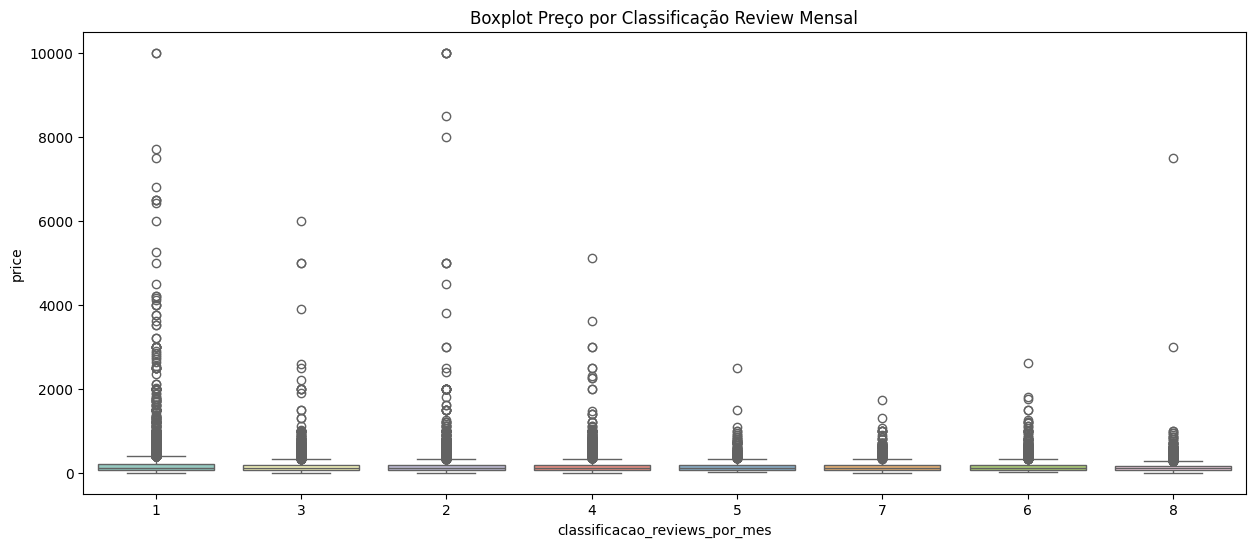

In [271]:
# Agrupar os dados por bairro e calcular a mediana do preço
rev = df.groupby('classificacao_reviews_por_mes').price.median().reset_index().sort_values(by=['price'],ascending=False)

# Selecionar apenas a coluna da Classificação Review por mes
rev = rev['classificacao_reviews_por_mes']

# Criar uma figura com tamanho 15x6
plt.figure(figsize=(15,6))

# Criar um boxplot usando seaborn com os dados originais, ordenando pela classificação e usando uma paleta de cores
ax = sns.boxplot(x='classificacao_reviews_por_mes', y='price', data=df, order=rev, palette=sns.color_palette("Set3", 10))

# Definir o título do gráfico como 'Boxplot Preço Classificação Review Mensal'
ax.set_title('Boxplot Preço por Classificação Review Mensal')

# Mostrar o gráfico
plt.show()

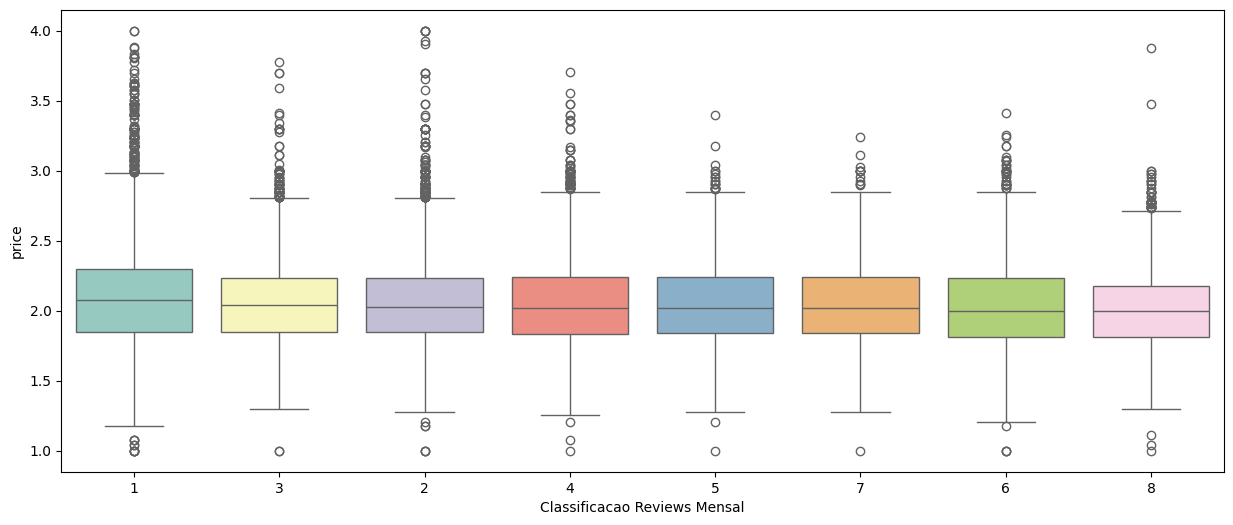

In [272]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
rev = df.groupby('classificacao_reviews_por_mes').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
rev = rev['classificacao_reviews_por_mes']

# Criar uma figura com tamanho 15x6
plt.figure(figsize = (15,6))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='classificacao_reviews_por_mes', y ='price', data = log, order = rev, palette = sns.color_palette("Set3", 10))

# Definir o rótulo do eixo x como 'Classificacao Reviews Mensal'
ax.set_xlabel('Classificacao Reviews Mensal')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* Há uma grande dispersão dos preços em todas as categorias, indicando que existem imóveis com preços muito diferentes dentro da mesma classificação de review mensal.
* Os outliers são mais frequentes e mais extremos nas categorias com menos reviews mensais, como as categorias 1 e 2. Isso pode sugerir que essas categorias contêm imóveis que são muito caros ou muito baratos em relação à média do mercado.
* As categorias com mais reviews mensais, como as categorias 5, 6, 7 e 8, têm uma distribuição mais concentrada dos preços, com menos outliers. Isso pode indicar que esses imóveis têm preços mais próximos da média do mercado e são mais padronizados.

Conclusões finais:

* Existe uma correlação negativa entre os reviews mensais e os preços dos imóveis, ou seja, quanto mais reviews um imóvel recebe, menor tende a ser o seu preço.
* Os imóveis com poucos ou nenhum review mensal podem ter preços mais altos por serem mais exclusivos, diferenciados ou desconhecidos pelos hóspedes.
* Os imóveis com muitos reviews mensais podem ter preços mais baixos por serem mais acessíveis, comuns ou em oferta pelos anfitriões.
* Há uma grande variação de preços dentro de cada categoria de review mensal, o que indica que outros fatores também influenciam o valor dos imóveis, como a localização, o tamanho, o tipo, os serviços, etc.

## Quantidade de Hosts

In [273]:
# Verificando os valores minimos e máximos de listagens
df.calculado_host_listings_count.min(), df.calculado_host_listings_count.max()

(np.int64(1), np.int64(327))

In [274]:
# Verificando quantos hosts fizeram determinadas quantidades de listagens
df.calculado_host_listings_count.value_counts().head()

calculado_host_listings_count
1    32303
2     6658
3     2853
4     1440
5      845
Name: count, dtype: int64

Como a variável "calculado_host_listings_count" tem muitos valores distintos, vamos classificá-los em grupos:

* Classificamos como 1 os valores com 1 listagem por host.
* Classificamos como 2 os valores com 2 e 3 listagens por host.
* Classificamos como 3 os valores de 4 e 10 Listagens por host.
* Classificamos como 4 os demais valores.

In [275]:
# Definindo os intervalos e os rótulos dos grupos
bins = [0, 1, 3, 10, np.inf]
labels = [1, 2, 3, 4]

# Criando uma nova coluna com a classificação dos valores em 9 grupos
df['classificacao_hosts'] = pd.cut(df['calculado_host_listings_count'], bins=bins, labels=labels)

# Mostrando o resultado
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,padrao,classificacao_reviews,classificacao_reviews_por_mes,classificacao_hosts
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,Skylit,8,3,2
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365,THE,1,1,1
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,Cozy,10,8,1
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,Entire,4,2,1
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,Large,8,4,1


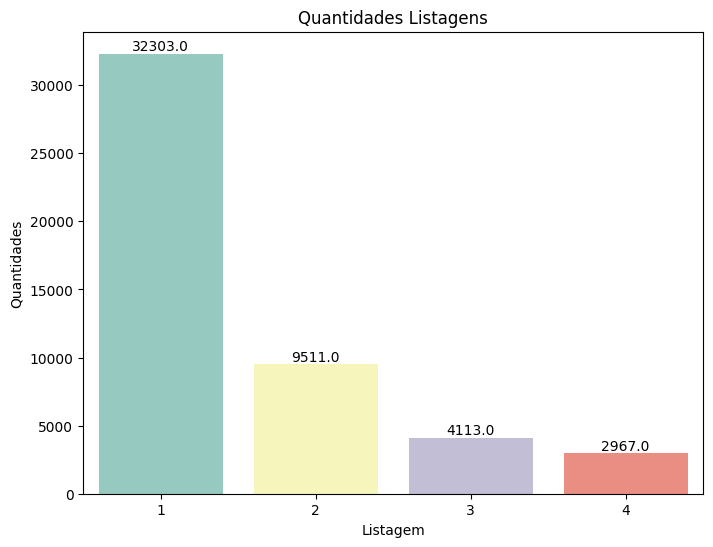

In [276]:
# Criar uma figura com tamanho 8x6
plt.figure(figsize=(8,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='classificacao_hosts', data=df, order= df['classificacao_hosts'].value_counts().index, palette=sns.color_palette("Set3"))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Host'
ax.set_xlabel('Listagem')

# Definir o rótulo do eixo y como 'Quantidades'
ax.set_ylabel('Quantidades')

# Definir o título do gráfico como 'Locações por bairro'
ax.set_title('Quantidades Listagens')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* Uma grande maioria dos hosts tem apenas uma listagem, como indicado pela barra verde. Este grupo constitui o maior segmento de longe.
* O número de hosts diminui à medida que o número de listagens por host aumenta. Essa tendência é visível pela redução drástica na quantidade da barra um para as barras dois a quatro.
* Hosts com mais de dez listagens são o menor grupo.

Em suma: Os dados visualizados neste gráfico indicam que a maioria dos hosts tem apenas uma listagem. À medida que avançamos para números mais altos de listagens por host, sua frequência diminui significativamente.

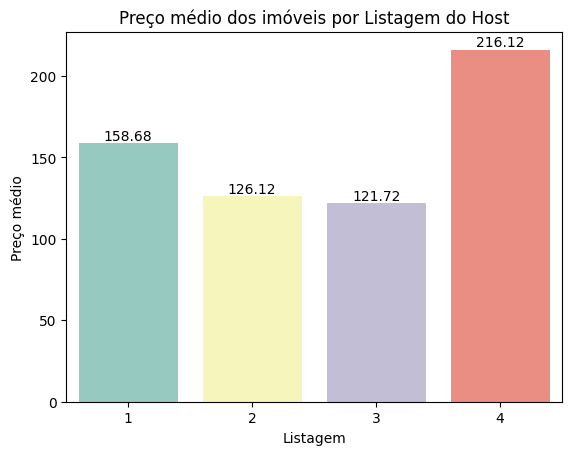

In [277]:
# Agrupar o dataframe por classificacao_hosts e calcular a média do preço
df_grouped = df.groupby('classificacao_hosts')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Listagem')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio dos imóveis por Listagem do Host')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, 
                         ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* Os anfitriões com apenas uma listagem têm um preço médio de propriedade moderadamente alto, de 158.68 dolares.
* Aqueles com duas ou três listagens têm preços médios mais baixos, em torno de 120 dolares, indicando que os anfitriões com menos listagens tendem a oferecer suas propriedades a preços mais competitivos.
* Curiosamente, os anfitriões que têm entre quatro e dez listagens também se enquadram nessa faixa de preços mais baixos, sugerindo que não há um aumento significativo nos preços das propriedades dentro dessa faixa de contagem de listagens.
* No entanto, os anfitriões com mais de dez listagens aumentam significativamente seus preços de propriedade, como evidenciado pelo aumento acentuado para um preço médio de mais de 216 dolares.

Concluindo, o gráfico mostra que há uma relação inversa entre o número de listagens por anfitrião e o preço médio das propriedades, exceto para os anfitriões com muitas listagens, que cobram preços muito mais altos do que os demais. Isso pode indicar que esses anfitriões têm propriedades de luxo ou de alta demanda, ou que eles estão explorando o mercado de aluguel de curto prazo. 

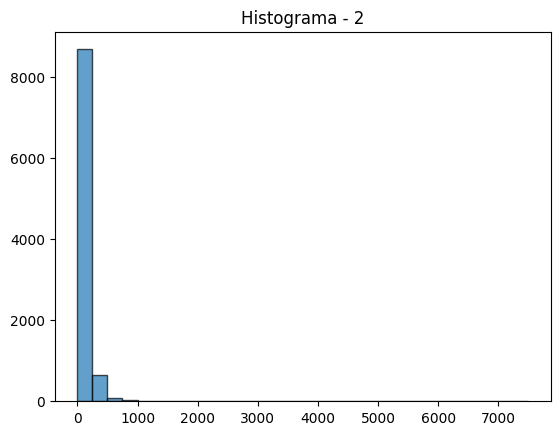

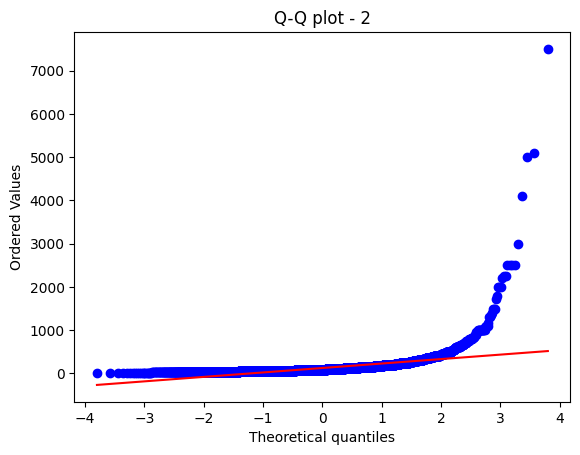

2 - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.



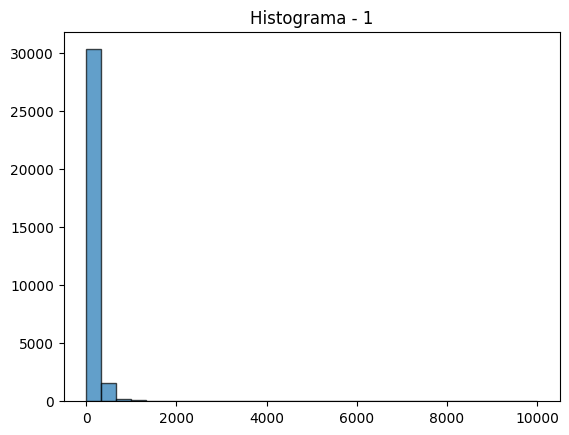

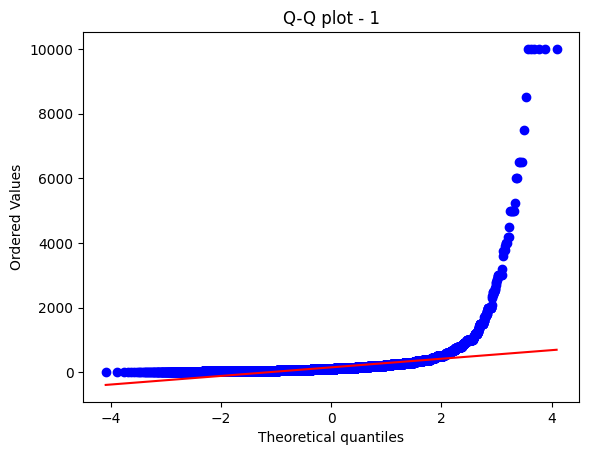

1 - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.



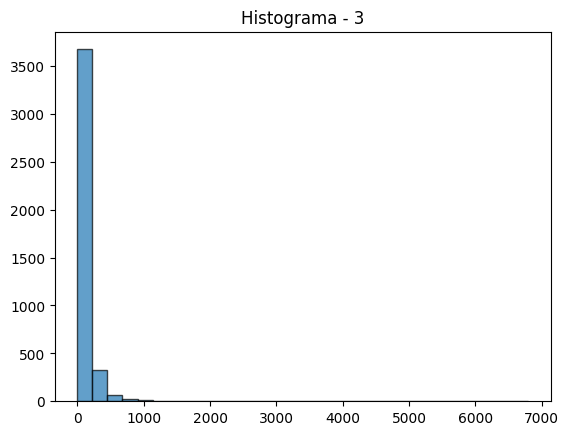

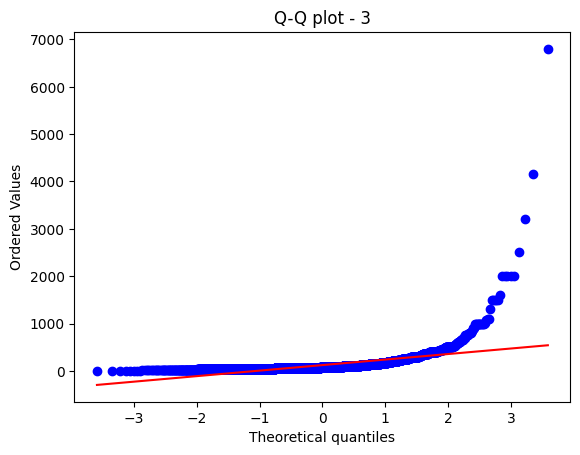

3 - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.



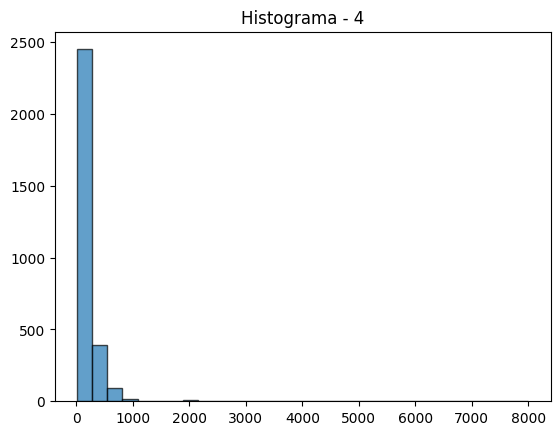

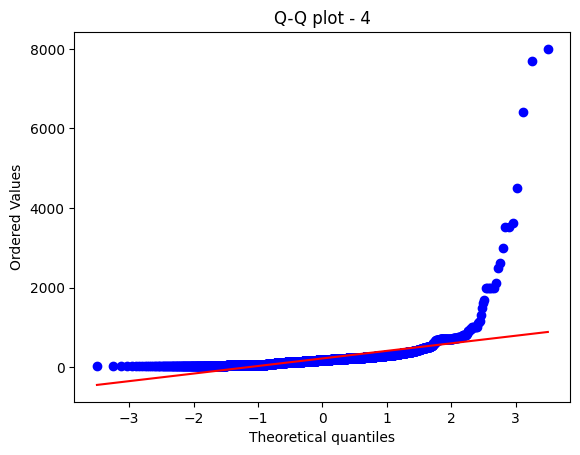

4 - Resultados dos Testes de Normalidade:
Shapiro-Wilk Teste: Rejeitar hipótese nula de normalidade.
Kolmogorov-Smirnov Teste: Rejeitar hipótese nula de normalidade.
Anderson-Darling Teste: Rejeitar hipótese nula de normalidade.



In [278]:
hosts_groups = df['classificacao_hosts'].unique()
for group in hosts_groups:
    dados = df['price'][df['classificacao_hosts'] == group]
    
    # Histograma
    plt.hist(dados, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Histograma - {group}')
    plt.show()
    
    # Q-Q plot
    stats.probplot(dados, dist="norm", plot=plt)
    plt.title(f'Q-Q plot - {group}')
    plt.show()
    
    # Testes de normalidade
    shapiro_test = stats.shapiro(dados)
    ks_test = stats.kstest(dados, 'norm')
    ad_test = stats.anderson(dados, dist='norm')
    
    print(f"{group} - Resultados dos Testes de Normalidade:")
    print(interpretar_normalidade(shapiro_test, ks_test, ad_test))

In [279]:
# Agrupar o dataframe por Listagem do Host e calcular a média do preço
df_grouped = df.groupby('classificacao_hosts')['price'].mean()

# Selecionar as séries de preços por Listagem do Host
one_listing = df['price'][df['classificacao_hosts'] == 1]
two_listings = df['price'][df['classificacao_hosts'] == 2]
three_listings = df['price'][df['classificacao_hosts'] == 3]
four_listings = df['price'][df['classificacao_hosts'] == 4]

# Realizar ANOVA
f_statistic, p_value = kruskal(one_listing, two_listings, three_listings, four_listings)

print(f"Estatística F: {f_statistic}")
print(f"Valor-p: {p_value}")

# A interpretação dos resultados depende do nível de significância escolhido alfa e.g., 0.05
alpha = 0.05
if p_value < alpha:
    print("Rejeitar a hipótese nula - As médias não são iguais.")
else:
    print("Não rejeitar a hipótese nula - Não há diferença significativa entre as médias.")

Estatística F: 2341.301553035432
Valor-p: 0.0
Rejeitar a hipótese nula - As médias não são iguais.


Ao realizar o teste de Kruskal para comparar as médias dos preços dos imóveis por Listagem do Host, obtivemos um valor-p muito baixo, o que significa que podemos rejeitar a hipótese nula de que as médias são iguais. Isso implica que há uma diferença estatisticamente significativa entre as médias dos preços dos imóveis por Listagem do Host.

Uma possível conclusão que podemos tirar com esses resultados é que a Listagem do Host influencia o preço do imóvel.

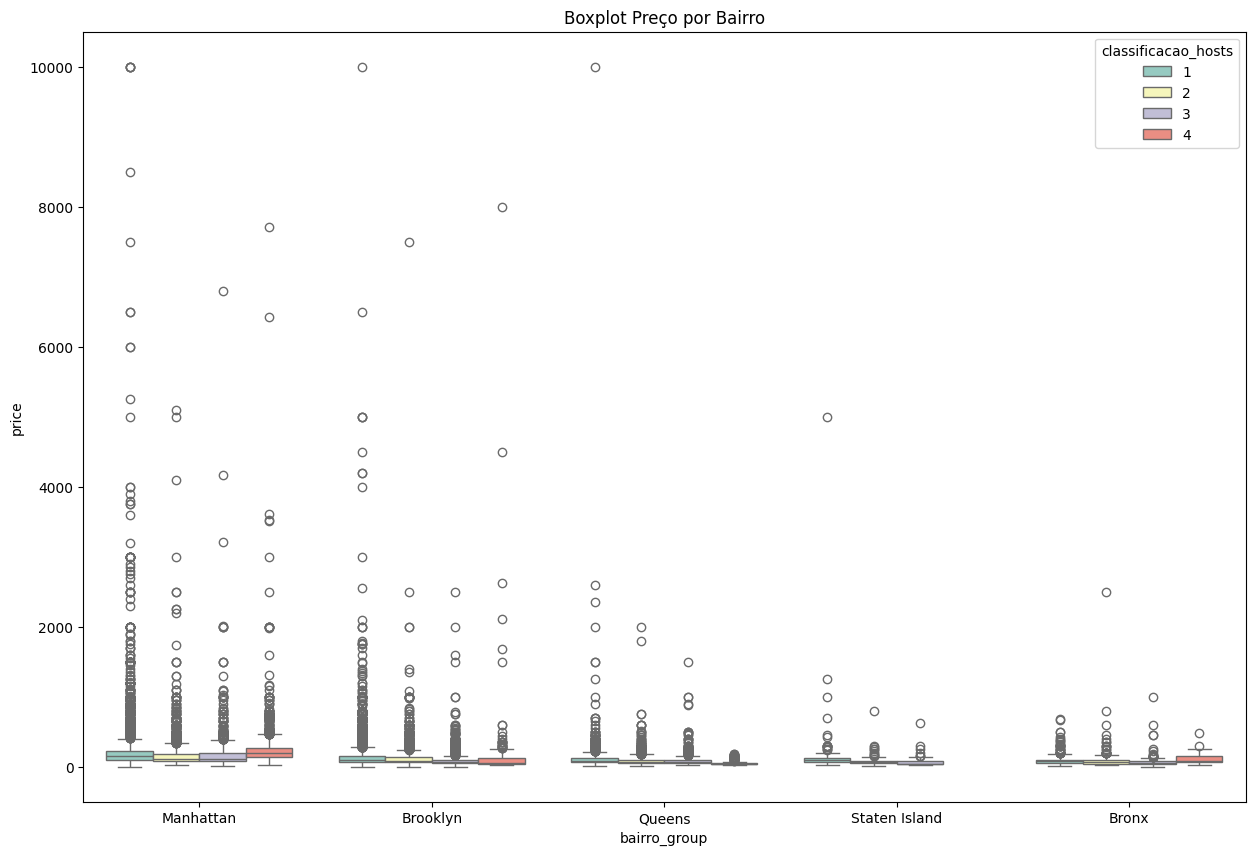

In [280]:
# Agrupar os dados por bairro e calcular a mediana do preço
bairros = df.groupby('bairro_group').price.median().reset_index().sort_values(by=['price'],ascending=False)

# Selecionar apenas a coluna do nome do bairro
bairros = bairros['bairro_group']

# Criar uma figura com tamanho 15x10
plt.figure(figsize=(15,10))

# Criar um boxplot usando seaborn com os dados originais, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='bairro_group', y='price', data=df, hue = 'classificacao_hosts',
                 order=bairros, palette=sns.color_palette("Set3", 4))

# Definir o título do gráfico como 'Boxplot Preço por Bairro'
ax.set_title('Boxplot Preço por Bairro')

# Mostrar o gráfico
plt.show()

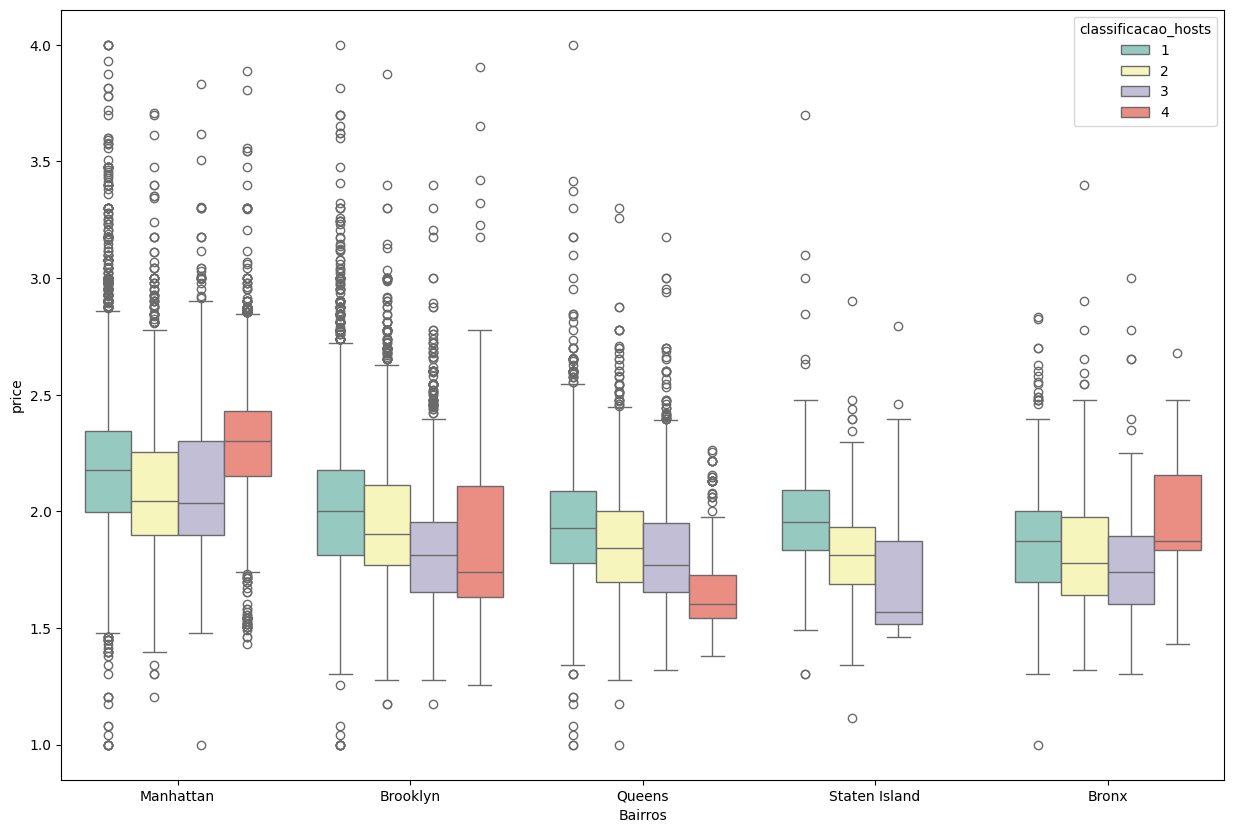

In [281]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
bairros = df.groupby('bairro_group').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
bairros = bairros['bairro_group']

# Criar uma figura com tamanho 15x10
plt.figure(figsize = (15,10))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='bairro_group', y ='price', data = log, 
                 hue = 'classificacao_hosts',order = bairros, 
                 palette = sns.color_palette("Set3", 4))

# Definir o rótulo do eixo x como 'Bairros'
ax.set_xlabel('Bairros')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* Há uma tendência notável de que os anfitriões com mais listagens (classificação 4) tendem a ter uma faixa maior de preços, incluindo outliers de preços mais altos, especialmente evidentes em Manhattan e Brooklyn. Isso pode indicar que esses anfitriões oferecem acomodações premium ou especializadas, levando a estruturas de preços variadas.
* Os anfitriões com menos listagens (classificações 1, 2 e 3) têm preços medianos semelhantes em todos os bairros, exceto em Manhattan, onde os preços são mais altos. Isso pode indicar que esses anfitriões competem entre si em um mercado mais saturado e homogêneo.
* Staten Island e Bronx têm poucos dados visíveis, o que pode sugerir que esses bairros são menos populares ou acessíveis para os viajantes. Os preços nesses bairros são consistentes em todas as classificações, indicando pouca variação na qualidade ou demanda das propriedades.

Em conclusão, o gráfico mostra que há uma relação entre o número de listagens por anfitrião, o preço das propriedades e o bairro onde estão localizadas. Os anfitriões com muitas listagens tendem a cobrar preços mais altos e variados, especialmente em bairros mais caros e desejados, enquanto os anfitriões com menos listagens tendem a cobrar preços mais baixos e consistentes, independentemente do bairro.

## Mês Alugado

In [282]:
# Converter a coluna data para o tipo datetime
df['ultima_review'] = pd.to_datetime(df['ultima_review'])

In [283]:
# Criar uma coluna nova com o mês da coluna "ultima_review"
df['mes_analise'] = df['ultima_review'].dt.month

In [284]:
# Trocar os valores NaN por 0 na coluna mes_analise
df['mes_analise'] = df['mes_analise'].fillna(0)

In [285]:
# Transformar a coluna mes_analise em inteiro, substituindo os valores não-finitos por NaN
df['mes_analise'] = df['mes_analise'].astype(int)

In [286]:
# Verificando os meses com mais quantidades de análises
df.mes_analise.value_counts().head(13)

mes_analise
6     13589
0     10052
7      5937
5      4701
1      2773
4      2109
12     1770
8      1667
10     1545
9      1535
3      1288
11     1158
2       770
Name: count, dtype: int64

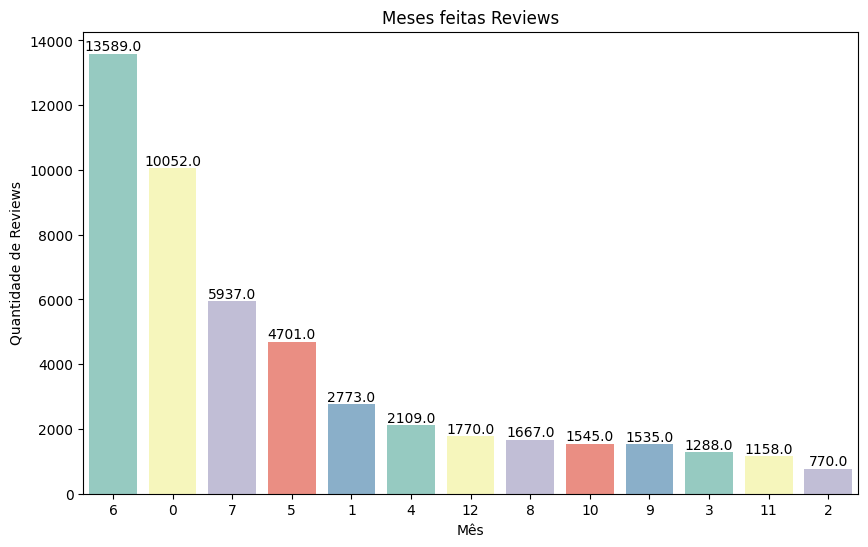

In [287]:
# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='mes_analise', data=df, order= df['mes_analise'].value_counts().index, palette=sns.color_palette("Set3", 5))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Classificacao Reviews Mensais'
ax.set_xlabel('Mês')

# Definir o rótulo do eixo y como 'Quantidades'
ax.set_ylabel('Quantidade de Reviews')

# Definir o título do gráfico como 'Quantidades de Reviews'
ax.set_title('Meses feitas Reviews')

# Mostrar o gráfico
plt.show()

* Um número significativo de aluguéis de apartamentos no estado de Nova York não recebeu nenhuma análise, como indicado pelo alto valor para o mês zero.
* Houve um pico de análises durante o sexto mês (junho); talvez haja uma razão ou sazonalidade subjacente que afete essa alta.
* Esse pico no sexto mês (Junho) se evidencia mais, vendo que os seus dois meses próximos mês 5 (maio) e 7(Julho) são os que mais apresentam reviews.
* As análises estão sendo feitas de forma consistente ao longo dos outros meses, mas em quantidades menores em comparação com os meses de Jumho, Julho e Maio e seis.

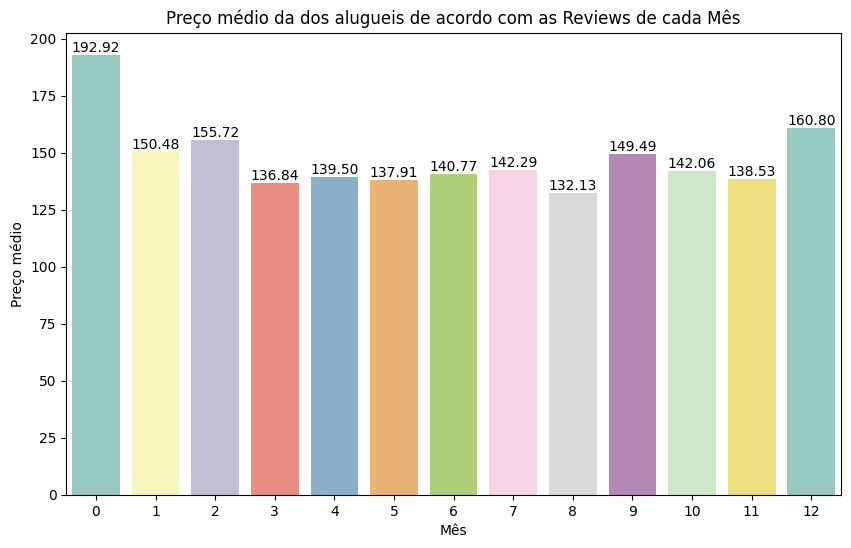

In [288]:
# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Agrupar o dataframe por review e calcular a média do preço
df_grouped = df.groupby('mes_analise')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Mês')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio da dos alugueis de acordo com as Reviews de cada Mês')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

* As avaliações parecem ter um impacto na redução dos preços de aluguel inicialmente.
* À medida que mais avaliações são acumuladas (a partir do mês zero sem avaliações), há uma diminuição notável nos preços de aluguel até cerca de meados do ano.
* No segundo semestre do ano, embora haja flutuações, uma tendência geral de aumento nos preços de aluguel pode ser observada.
* Isso sugere que, à medida que mais informações ficam disponíveis por meio das avaliações, os potenciais inquilinos podem estar dispostos a pagar um pouco mais pela qualidade ou outros fatores destacados nas avaliações.

In [289]:
# Agrupar o dataframe por Reviews por mês e calcular a média do preço
df_grouped = df.groupby('mes_analise')['price'].mean()

# Selecionar as séries de preços por Reviews por mês
noreview = df['price'][df['mes_analise'] == 0]
january = df['price'][df['mes_analise'] == 1]
february = df['price'][df['mes_analise'] == 2]
march = df['price'][df['mes_analise'] == 3]
april = df['price'][df['mes_analise'] == 4]
may = df['price'][df['mes_analise'] == 5]
june = df['price'][df['mes_analise'] == 6]
july = df['price'][df['mes_analise'] == 7]
august = df['price'][df['mes_analise'] == 8]
september = df['price'][df['mes_analise'] == 9]
october = df['price'][df['mes_analise'] == 10]
november = df['price'][df['mes_analise'] == 11]
december = df['price'][df['mes_analise'] == 12]

# Realizar ANOVA
f_statistic, p_value = stats.f_oneway(noreview, january, february, march, april, may, june, july, august, september, october, november, december)

print(f"Estatística F: {f_statistic}")
print(f"Valor-p: {p_value}")

# A interpretação dos resultados depende do nível de significância escolhido alfa e.g., 0.05
alpha = 0.05
if p_value < alpha:
    print("Rejeitar a hipótese nula - As médias não são iguais.")
else:
    print("Não rejeitar a hipótese nula - Não há diferença significativa entre as médias.")

Estatística F: 31.767947870513716
Valor-p: 7.205399895604772e-74
Rejeitar a hipótese nula - As médias não são iguais.


Ao realizar o teste de ANOVA para comparar as médias dos preços dos alugueis de acordo com as Reviews de cada mês, obtivemos um valor-p muito baixo, o que significa que podemos rejeitar a hipótese nula de que as médias são iguais. Isso implica que há uma diferença estatisticamente significativa entre as médias dos preços dos alugueis por Reviews de cada mês.

Uma possível conclusão que podemos tirar com esses resultados é que as Reviews influenciam no preço dos alugueis.

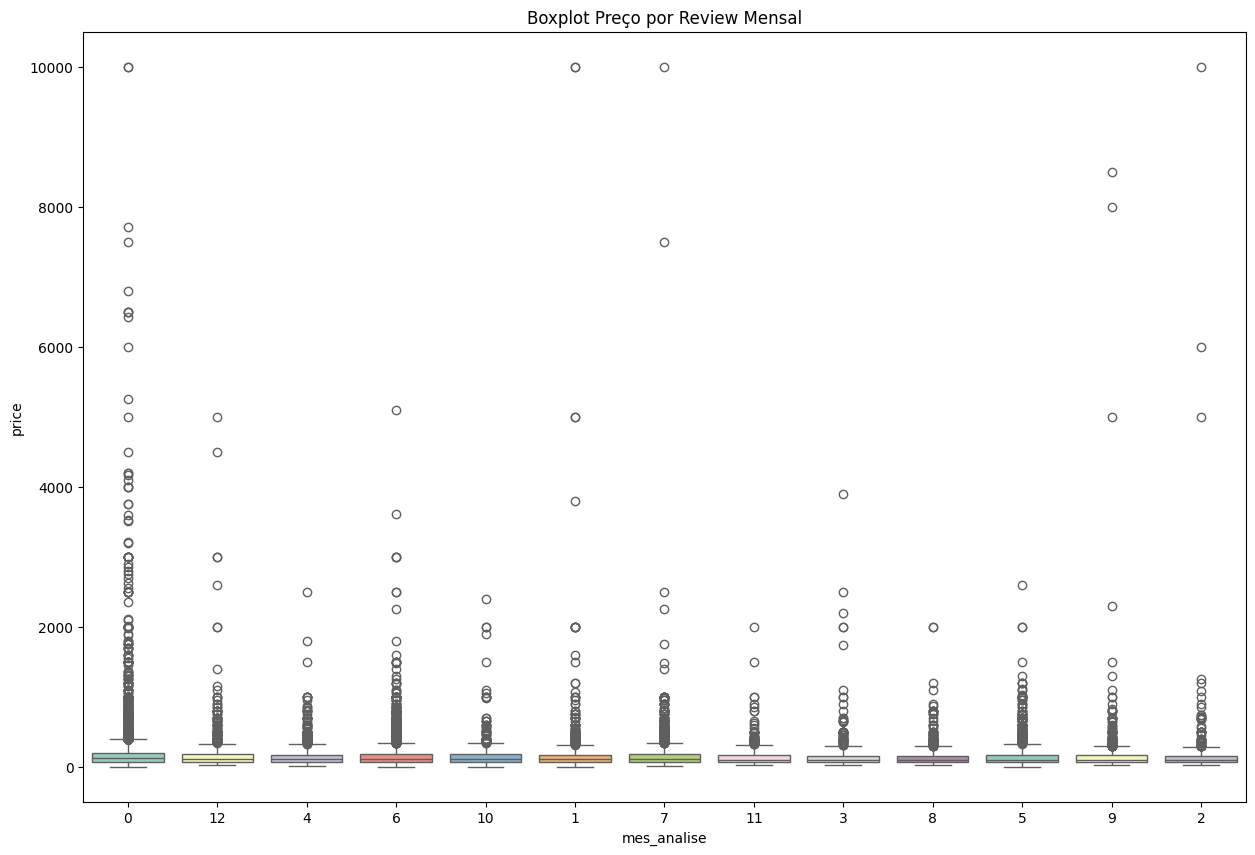

In [290]:
# Agrupar os dados por bairro e calcular a mediana do preço
mes = df.groupby('mes_analise').price.median().reset_index().sort_values(by=['price'],ascending=False)

# Selecionar apenas a coluna da Classificação Review por mes
mes = mes['mes_analise']

# Criar uma figura com tamanho 15x10
plt.figure(figsize=(15,10))

# Criar um boxplot usando seaborn com os dados originais, ordenando pela classificação e usando uma paleta de cores
ax = sns.boxplot(x='mes_analise', y='price', data=df, order=mes, palette=sns.color_palette("Set3", 10))

# Definir o título do gráfico como 'Boxplot Preço Classificação Review Mensal'
ax.set_title('Boxplot Preço por Review Mensal')

# Mostrar o gráfico
plt.show()

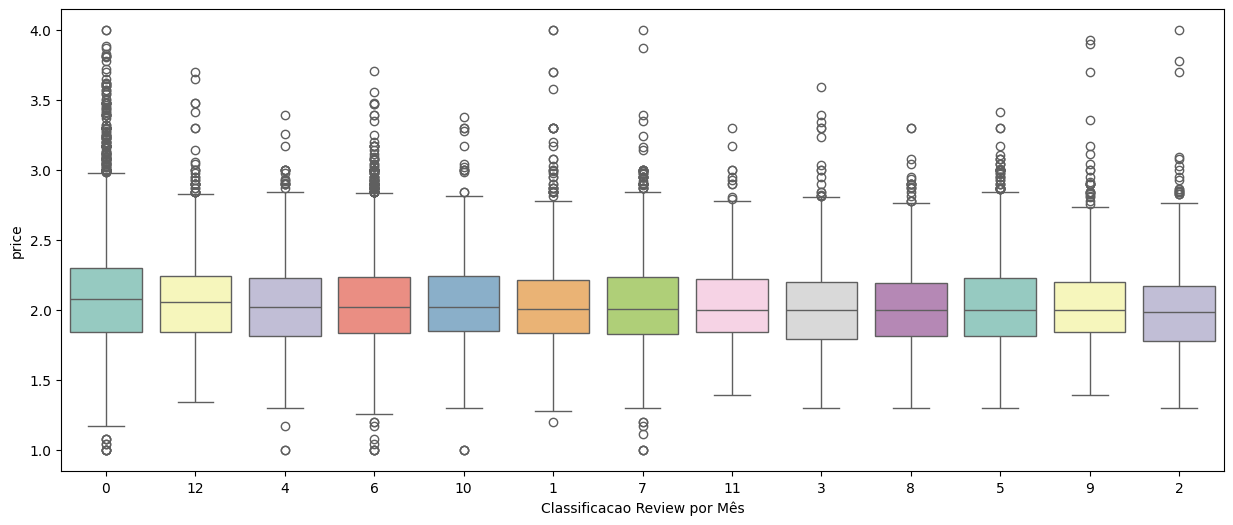

In [291]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
rev = df.groupby('mes_analise').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do Mês
rev = rev['mes_analise']

# Criar uma figura com tamanho 15x6
plt.figure(figsize = (15,6))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='mes_analise', y ='price', data = log, order = rev, palette = sns.color_palette("Set3", 10))

# Definir o rótulo do eixo x como 'Classificacao Reviews Mensal'
ax.set_xlabel('Classificacao Review por Mês')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

* Há uma pequena variação nos preços de aluguel a cada mês, exceto no mês zero.
* Não há uma tendência clara mostrando que os preços são consistentemente mais altos ou mais baixos em meses específicos; em vez disso, há uma variabilidade significativa dentro de cada mês.
* Os valores extremos indicam que há alguns apartamentos com preços de aluguel excepcionalmente altos em todos os meses.

## Disponibilidade

In [292]:
# Verificando os valores minimos e máximos de disponibilidade
df.disponibilidade_365.min(), df.disponibilidade_365.max()

(np.int64(0), np.int64(365))

In [293]:
# Verificando quantos hosts fizeram determinadas quantidades de disponibilidade
df.disponibilidade_365.value_counts().head()

disponibilidade_365
0      17533
365     1294
364      491
1        408
89       361
Name: count, dtype: int64

Como a variável "disponibilidade_365" tem muitos valores distintos, vamos classificá-los em 12 meses:

* Classificamos como 1 mês os valores de 0 a 30.
* Classificamos como 2 meses os valores de 31 a 60.
* Classificamos como 3 meses os valores de 61 a 90.
* Classificamos como 4 meses os valores de 91 a 120.
* Classificamos como 5 meses os valores de 121 a 150.
* Classificamos como 6 meses os valores de 151 a 180.
* Classificamos como 7 meses os valores de 181 a 210.
* Classificamos como 8 meses os valores de 211 a 240.
* Classificamos como 9 meses os valores de 241 a 270.
* Classificamos como 10 meses os valores de 271 a 300.
* Classificamos como 11 meses os valores de 301 a 330.
* Classificamos como 12 meses os valores de 331 a 365.

In [294]:
# Definindo os intervalos e os rótulos dos grupos
bins = [-1, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, np.inf]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Criando uma nova coluna com a classificação dos valores em 12 grupos
df['classificacao_disponibilidade'] = pd.cut(df['disponibilidade_365'], bins=bins, labels=labels)

# Mostrando o resultado
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,...,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,padrao,classificacao_reviews,classificacao_reviews_por_mes,classificacao_hosts,mes_analise,classificacao_disponibilidade
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,2019-05-21,0.38,2,355,Skylit,8,3,2,5,12
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,NaT,0.00,1,365,THE,1,1,1,0,12
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,2019-07-05,4.64,1,194,Cozy,10,8,1,7,7
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,2018-11-19,0.10,1,0,Entire,4,2,1,11,1
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,...,2019-06-22,0.59,1,129,Large,8,4,1,6,5


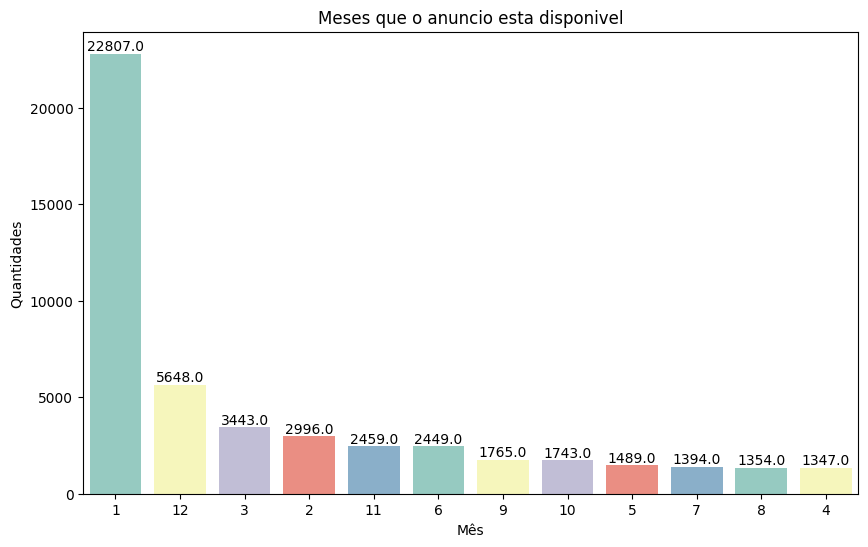

In [295]:
# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='classificacao_disponibilidade', data=df, order= df['classificacao_disponibilidade'].value_counts().index, palette=sns.color_palette("Set3", 5))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Classificacao Reviews Mensais'
ax.set_xlabel('Mês')

# Definir o rótulo do eixo y como 'Quantidades'
ax.set_ylabel('Quantidades')

# Definir o título do gráfico como 'Quantidades de Reviews'
ax.set_title('Meses que o anuncio esta disponivel')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* A maioria dos anúncios está disponível apenas por um mês, com 22.807 anúncios nessa categoria.
* Há uma redução drástica na disponibilidade à medida que o número de meses aumenta, indicando que os anfitriões preferem alugar seus espaços por períodos curtos.
* Anúncios disponíveis por períodos prolongados, como doze meses ou mais, são relativamente raros, com apenas 5.648 anúncios nessa categoria.

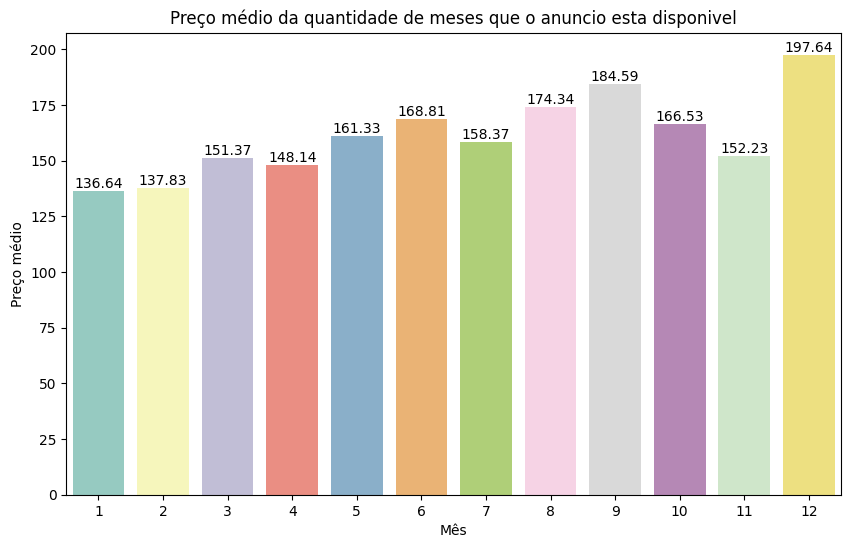

In [296]:
# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Agrupar o dataframe por review e calcular a média do preço
df_grouped = df.groupby('classificacao_disponibilidade')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Mês')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio da quantidade de meses que o anuncio esta disponivel')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* O preço médio aumenta com o aumento do número de meses que o anúncio está disponível, com exceção do 10º mês.
* O menor preço médio é observado no primeiro mês (136,64) e o maior no 12º mês (197,64).
* Há uma variação notável nos preços médios. Eles não seguem um padrão linear ou constante evidente. Porém quanto maior a disponibilidade dos meses, pode-se notar um leve aumento nos preços.

In [297]:
# Agrupar o dataframe por classificacao_disponibilidade e calcular a média do preço
df_grouped = df.groupby('classificacao_disponibilidade')['price'].mean()

# Selecionar as séries de preços por classificacao_disponibilidade
one_month = df['price'][df['classificacao_disponibilidade'] == 1]
two_months = df['price'][df['classificacao_disponibilidade'] == 2]
three_months = df['price'][df['classificacao_disponibilidade'] == 3]
four_months = df['price'][df['classificacao_disponibilidade'] == 4]
five_months = df['price'][df['classificacao_disponibilidade'] == 5]
six_months = df['price'][df['classificacao_disponibilidade'] == 6]
seven_months = df['price'][df['classificacao_disponibilidade'] == 7]
eight_months = df['price'][df['classificacao_disponibilidade'] == 8]
nine_months = df['price'][df['classificacao_disponibilidade'] == 9]
ten_months = df['price'][df['classificacao_disponibilidade'] == 10]
eleven_months = df['price'][df['classificacao_disponibilidade'] == 11]
twelve_months = df['price'][df['classificacao_disponibilidade'] == 12]

# Realizar ANOVA
f_statistic, p_value = stats.f_oneway(one_month, two_months, three_months, four_months, five_months, six_months, seven_months, eight_months, nine_months, ten_months, eleven_months, twelve_months)

print(f"Estatística F: {f_statistic}")
print(f"Valor-p: {p_value}")

# A interpretação dos resultados depende do nível de significância escolhido alfa e.g., 0.05
alpha = 0.05
if p_value < alpha:
    print("Rejeitar a hipótese nula - As médias não são iguais.")
else:
    print("Não rejeitar a hipótese nula - Não há diferença significativa entre as médias.")

Estatística F: 34.20021854063414
Valor-p: 1.3584268266487943e-73
Rejeitar a hipótese nula - As médias não são iguais.


Ao realizar o teste de ANOVA para comparar as médias dos preços da quantidade de meses que o anúncio está disponível, obtivemos um valor-p muito baixo, o que significa que podemos rejeitar a hipótese nula de que as médias são iguais. Isso implica que há uma diferença estatisticamente significativa entre as médias dos preços da quantidade de meses que o anúncio está disponível.

Uma possível conclusão que podemos tirar com esses resultados é que a disponibilidade do anúncio influencia o preço do aluguel, e que os anúncios que ficam disponíveis por mais tempo são, em média, mais caros do que os que ficam disponíveis por menos tempo.

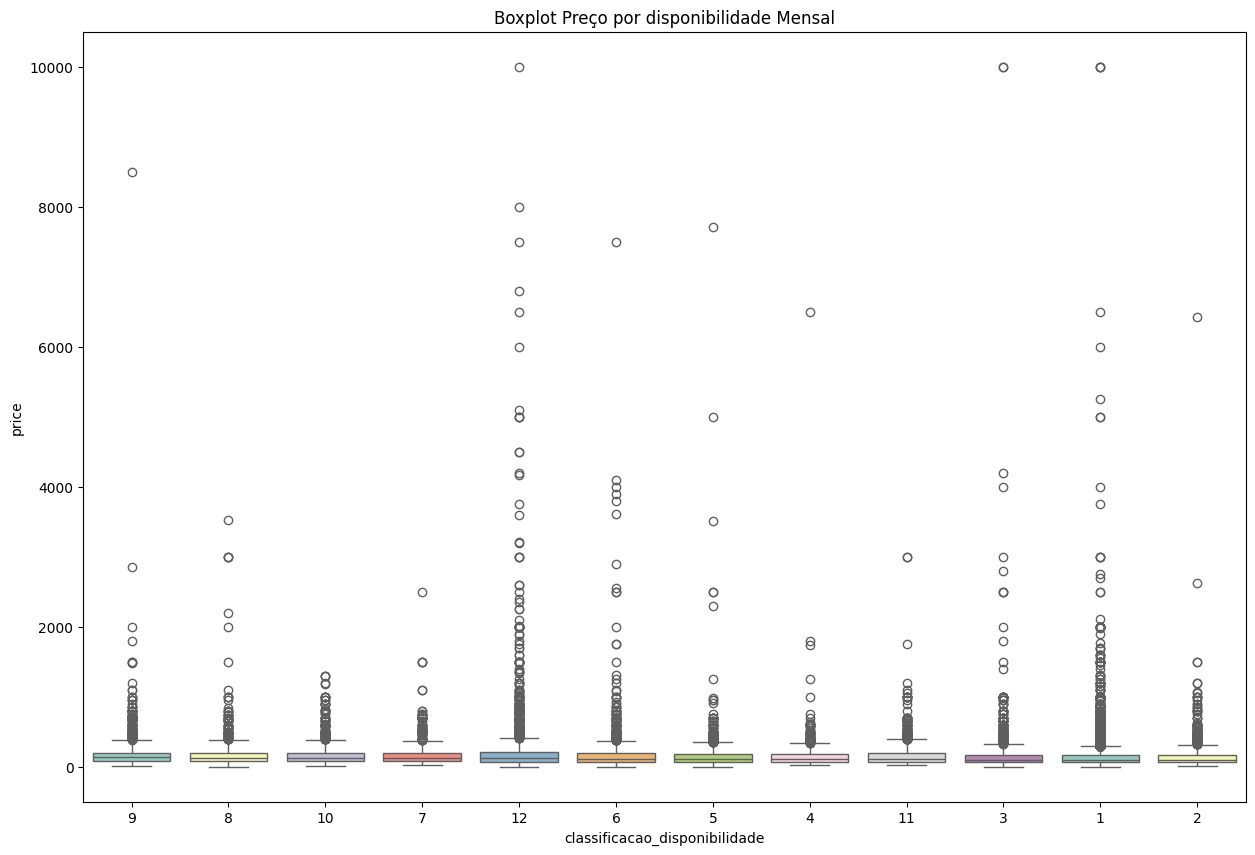

In [298]:
# Agrupar os dados por bairro e calcular a mediana do preço
mes = df.groupby('classificacao_disponibilidade').price.median().reset_index().sort_values(by=['price'],ascending=False)

# Selecionar apenas a coluna da Classificação Review por mes
mes = mes['classificacao_disponibilidade']

# Criar uma figura com tamanho 15x10
plt.figure(figsize=(15,10))

# Criar um boxplot usando seaborn com os dados originais, ordenando pela classificação e usando uma paleta de cores
ax = sns.boxplot(x='classificacao_disponibilidade', y='price', data=df, order=mes, palette=sns.color_palette("Set3", 10))

# Definir o título do gráfico como 'Boxplot Preço Classificação Review Mensal'
ax.set_title('Boxplot Preço por disponibilidade Mensal')

# Mostrar o gráfico
plt.show()

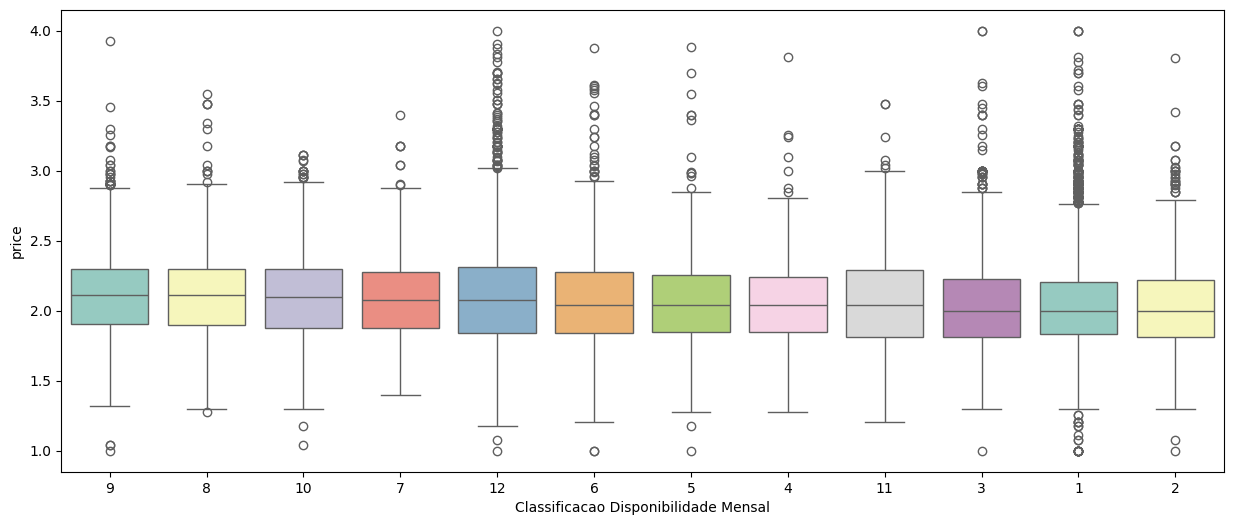

In [299]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
rev = df.groupby('classificacao_disponibilidade').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
rev = rev['classificacao_disponibilidade']

# Criar uma figura com tamanho 15x6
plt.figure(figsize = (15,6))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='classificacao_disponibilidade', y ='price', data = log, order = rev, palette = sns.color_palette("Set3", 10))

# Definir o rótulo do eixo x como 'Classificacao Reviews Mensal'
ax.set_xlabel('Classificacao Disponibilidade Mensal')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* Há uma grande variação nos preços dentro de cada categoria de disponibilidade mensal, como indicado pela altura das caixas e pela presença de outliers.
* Outliers são comuns, indicando que há ocasionalmente preços muito mais altos do que a mediana em cada categoria.
* O preço mediano parece relativamente consistente entre as diferentes categorias de disponibilidade mensal, como indicado pela linha horizontal dentro de cada caixa.

# Pré-Processamento

O que será feito:

* Transformar os valores "object" em "int", para poderem ser rodados nos modelos de machine learning.
* Remover a feature "nome" por conter uma grande variedade de nomes dos anúncios.
* Remover a coluna "id", "host_id", "host_name", pois são variaveis que não irão impactar no modelo.
* Remover a coluna "ultima_review", pois não iremos usar essa informação no modelo.
* Remover a feature "bairro", tendo em vista que iremos usar apenas a feature "bairro_group" em nosso modelo.
* Também iremos remover as features "numero_de_reviews", "reviews_por_mes", "calculado_host_listings_count", "disponibilidade_365" e "ultima_review",pois iremos substitui-las por seus agrupamentos feitos na EDA.
* Realizar um LabelEncoder: transformação de variáveis categóricas em numéricas.
* Criar variáveis Dummyes para as features com pouca variedade de informações.
* Seram removidos os valores Outliers, com preços muito altos. Acima de 400 dolares, pois esses dados representão uma procentagem muito pequena de toda a base de dados e mantes esses valores causariam impactos negativos no modelo.

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48894 non-null  int64         
 1   nome                           48878 non-null  object        
 2   host_id                        48894 non-null  int64         
 3   host_name                      48873 non-null  object        
 4   bairro_group                   48894 non-null  object        
 5   bairro                         48894 non-null  object        
 6   latitude                       48894 non-null  float64       
 7   longitude                      48894 non-null  float64       
 8   room_type                      48894 non-null  object        
 9   price                          48894 non-null  int64         
 10  minimo_noites                  48894 non-null  int64         
 11  numero_de_revie

In [301]:
# Converter as colunas classificacao_reviews, classificacao_reviews_por_mes, classificacao_hosts e classificacao_disponibilidade para int
df[['classificacao_reviews', 'classificacao_reviews_por_mes', 'classificacao_hosts', 'classificacao_disponibilidade']] = df[['classificacao_reviews', 
                                                                                                                             'classificacao_reviews_por_mes', 
                                                                                                                             'classificacao_hosts', 'classificacao_disponibilidade']].astype(int)

In [302]:
# Selecionando as colunas a serem removidas
colunas = ['id', 'nome', 'host_id', 'host_name', 'bairro', 'padrao',
           'numero_de_reviews', 'ultima_review', 'reviews_por_mes', 
           'calculado_host_listings_count', 'disponibilidade_365']

# chamando a função auxiliar para excluir as colunas selecionadas
df = excluir_colunas(df, colunas)

In [303]:
# Visualizando os valores a serem removidos
df[(df['price'] > 400)]

,bairro_group,latitude,longitude,room_type,price,minimo_noites,classificacao_reviews,classificacao_reviews_por_mes,classificacao_hosts,mes_analise,classificacao_disponibilidade
84,Brooklyn,40.69723,-73.99268,Entire home/apt,800,1,6,2,1,8,1
102,Manhattan,40.73096,-74.00319,Entire home/apt,500,4,8,4,2,5,9
157,Brooklyn,40.68559,-73.98094,Entire home/apt,475,3,6,3,1,12,8
232,Manhattan,40.72003,-74.00262,Entire home/apt,500,4,9,4,1,6,11
241,Manhattan,40.74358,-74.00027,Entire home/apt,500,2,7,3,1,7,12
...,...,...,...,...,...,...,...,...,...,...,...
48739,Brooklyn,40.69827,-73.99649,Entire home/apt,550,3,2,4,1,7,8
48743,Brooklyn,40.71091,-73.96560,Entire home/apt,499,30,1,1,1,0,12
48756,Manhattan,40.71815,-74.01145,Entire home/apt,700,3,1,1,1,0,2
48832,Manhattan,40.70605,-74.01042,Entire home/apt,475,2,1,1,1,0,3


In [304]:
# Obtendo os índices das linhas que atendem às condições
indices = df.loc[(df['price'] > 400)].index

# Removendo as linhas usando o método drop
df = df.drop(indices, axis=0)

In [305]:
# Verificando se existe valores nulos no dataframe
df.isnull().sum()

bairro_group                     0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
classificacao_reviews            0
classificacao_reviews_por_mes    0
classificacao_hosts              0
mes_analise                      0
classificacao_disponibilidade    0
dtype: int64

## LabelEncoder: transformação de variáveis categóricas em numéricas

O LabelEncoder converte rótulos categóricos em valores numéricos. As variáveis categóricas são convertidas em variáveis numéricas em tarefas de aprendizado de máquina.

In [306]:
# Chamando a função para transformas os valores str em numericos
#df = label_encode_columns(df, ['bairro_group', 'room_type'])

In [307]:
#df.head()

## Hot encoder

A codificação one-hot pode converter variáveis categóricas em variáveis numéricas binárias. Sendo útil para muitos algoritmos de aprendizado de máquina que usam apenas entradas numéricas. Para cada valor único da variável categórica, a codificação one-hot cria uma nova coluna e preenche com 1 se o valor corresponde à coluna e com 0 caso contrário.

In [308]:
# Definindo a lista de colunas categóricas que devem ser codificadas
col_list = ['bairro_group', 'room_type']
# Aplicando a função to_one_hot_encoding no DataFrame original
df = to_one_hot_encoding(df, col_list)
# O resultado é um DataFrame com as colunas categóricas codificadas usando a codificação one-hot

## Seleção de Variáveis

Agora examinaremos se as características (features) dos dados estão correlacionadas, ou seja, se elas estão ligadas. Um valor numérico que vai de zero a um e representa a direção e a força da relação entre duas variáveis é chamado de "correlação". Como as variáveis têm uma forte relação positiva entre si, a correlação entre elas é próxima de 1. Em outras palavras, ao aumentar uma das variáveis, também aumenta an outra. Se a correlação entre as variáveis estiver próxima do negativo de um, a relação entre elas será significativamente negativa. Em outras palavras, ao aumentar uma das variáveis, a diminuição da outra ocorre. Se a correlação for quase zero, isso indica que as variáveis não dependem uma da outra, ou que há uma baixa relação entre elas.

Para nosso problema, irei verificar se há uma forte correlação positiva entre as duas features, que significa que os dados são quase idênticos se for maior ou igual a 0,9. Isso pode ser um problema para a análise quando as características são altamente dependentes umas das outras, como redundância e multicolinearidade. Nesse caso, podemos remover uma das características, pois ela não adiciona informações relevantes ao modelo.

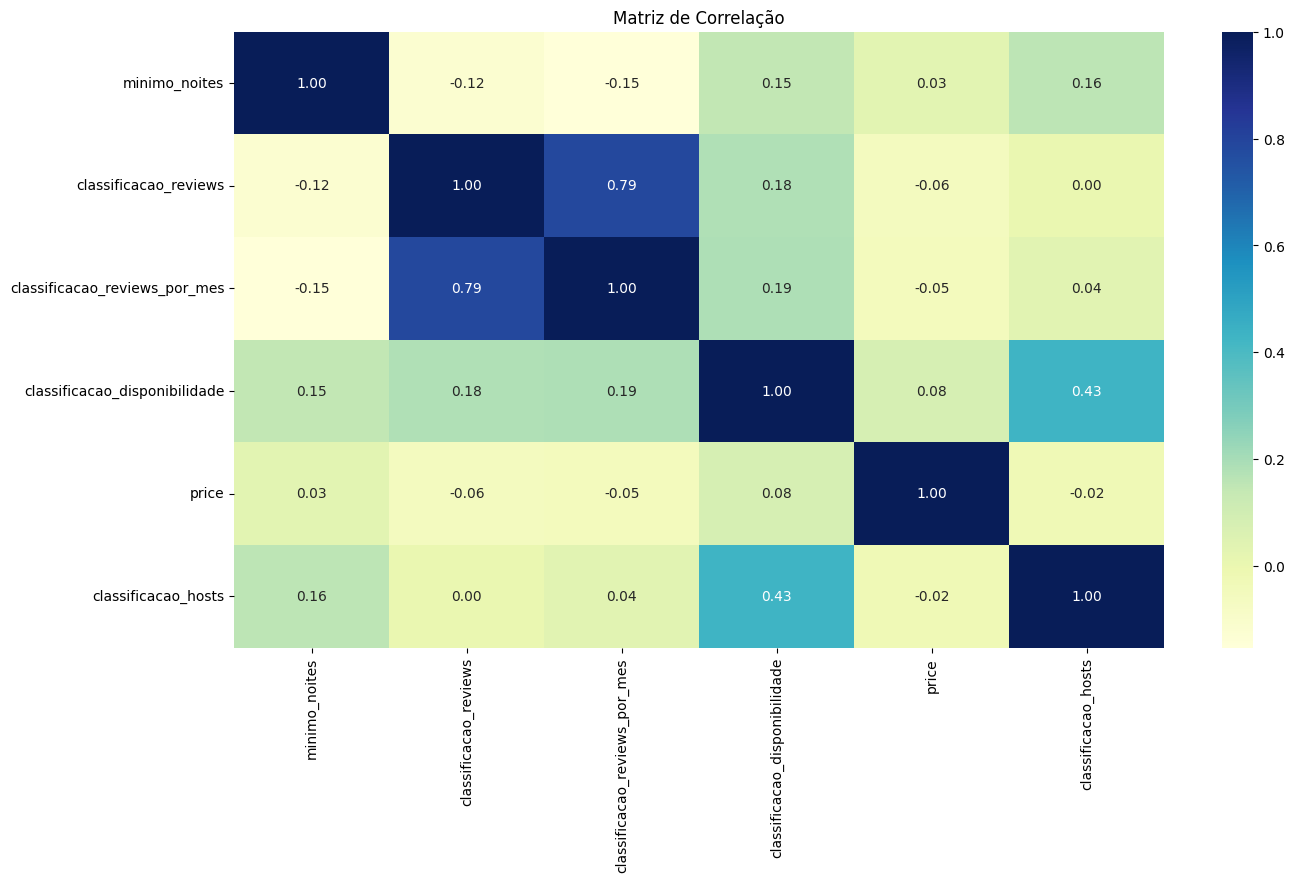

In [309]:
# Calcula a matriz de correlação das colunas selecionadas do dataframe df
corr = df[['minimo_noites', 'classificacao_reviews', 'classificacao_reviews_por_mes',
            'classificacao_disponibilidade', 'price', 'classificacao_hosts']].corr()

# Cria uma figura com um tamanho específico
plt.figure(figsize = (15, 8))

# Cria um mapa de calor da matriz de correlação, usando uma paleta de cores, um formato de números e mostrando os valores nas células
sns.heatmap(corr, annot = True, cmap = "YlGnBu", fmt = ".2f")

# Adiciona um título à figura
plt.title("Matriz de Correlação")

# Mostra a figura na tela
plt.show()

Para considerarmos uma correlação como forte o suficiente para justificar a remoção de uma variável, seria necessário que a correlação estivesse acima de 0.9. Como a maior correlação que temos é de 0.79 entre classificacao_reviews e classificacao_reviews_por_mes, não iremos remover nenhuma variável.

In [310]:
correlated_columns = remover_recursos_correlacionados(df)
correlated_columns

([('room_type_private_room', 'room_type_entire_home/apt')],
 {'room_type_private_room'})

Como nenhuma das variaveis apresentam uma forte correlação entre si, logo todas as variaveis serão usadas no modelo de predição.

## Particionamento dos Dados

In [311]:
# Definindo uma semente aleatória para reproduzibilidade
SEED = 30

In [312]:
# Divide o dataframe df_model em dois subconjuntos: df_train e df_test
# O tamanho do subconjunto de teste é 20% do dataframe original
# O parâmetro random_state recebe o valor da semente definida anteriormente
df_train, df_test = train_test_split(df, test_size=0.2, random_state = SEED)

In [313]:
# Separa as variáveis explicativas (X) e a variável resposta (y) do dataframe de treino
# O método drop() remove a coluna 'price' do dataframe e retorna um novo dataframe sem ela
# O parâmetro axis=1 indica que a operação é feita nas colunas e não nas linhas
X_train = df_train.drop('price', axis=1)
# A variável resposta é a coluna 'price' do dataframe de treino
y_train = df_train['price']

# Repete o mesmo processo para o dataframe de teste
X_test = df_test.drop('price', axis=1)
y_test = df_test['price']

In [314]:
# Verificando o tamanho
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37704, 16), (9427, 16), (37704,), (9427,))

## Seleção dos algoritmos de Machine Learning

Usaremos o coeficiente de determinação (R²) como métrica para avaliar o desempenho dos modelos de regressão. O R² mede o quanto da variação da variável dependente é explicada pelas variáveis independentes, sendo 1 o valor máximo e 0 o valor mínimo. Quanto maior o R², melhor o modelo se ajusta aos dados.

In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47131 entries, 0 to 48893
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   latitude                       47131 non-null  float64
 1   longitude                      47131 non-null  float64
 2   price                          47131 non-null  int64  
 3   minimo_noites                  47131 non-null  int64  
 4   classificacao_reviews          47131 non-null  int64  
 5   classificacao_reviews_por_mes  47131 non-null  int64  
 6   classificacao_hosts            47131 non-null  int64  
 7   mes_analise                    47131 non-null  int64  
 8   classificacao_disponibilidade  47131 non-null  int64  
 9   bairro_group_bronx             47131 non-null  int64  
 10  bairro_group_brooklyn          47131 non-null  int64  
 11  bairro_group_manhattan         47131 non-null  int64  
 12  bairro_group_queens            47131 non-null  int6

Regressão Linear Múltipla: 0.444531 (0.011047)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 30163, number of used features: 16
[LightGBM] [Info] Start training from score 125.994264
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 30163, number of used features: 16
[LightGBM] [Info] Start training from score 126.380101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` t

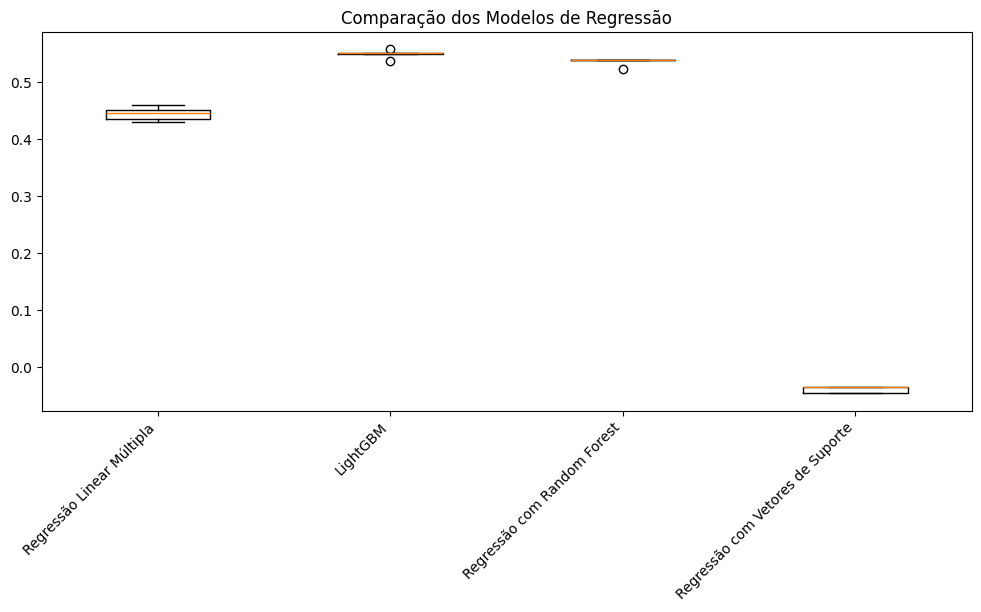

In [316]:
# Definindo os modelos de regressão
RLM = LinearRegression() # Regressão linear múltipla
LGBM = lgb.LGBMRegressor(random_state=SEED)  # LightGBM
RFR = RandomForestRegressor(random_state=SEED) # Regressão com random forest
SVR = SVR() # Regressão com vetores de suporte

# Modelos que serão usados
models = [RLM, LGBM, RFR, SVR]

# Nome dos modelos que serão usados
model_names = ["Regressão Linear Múltipla", "LightGBM", "Regressão com Random Forest", "Regressão com Vetores de Suporte"]

results = []

# Treino dos modelos
for item in models:
    kfold = KFold(n_splits=5, random_state=SEED, shuffle=True)
    cv_results = cross_val_score(item, X_train, y_train, cv=kfold, scoring='r2')
    results.append(cv_results)
    msg = "%s: %f (%f)" % (model_names[models.index(item)], cv_results.mean(), cv_results.std())
    print(msg)

# Plot comparação dos modelos
fig, ax = plt.subplots(figsize=(10, 6))  
ax.boxplot(results)
ax.set_xticklabels(model_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.title('Comparação dos Modelos de Regressão')
plt.show()

Baseado nos resultados e na visualização, iremos escolher o modelo de Regressão Linear Múltipla e Random Forest. O motivo é que ele tem o maior valor médio entre todos os modelos, indicando um melhor desempenho em termos da métrica avaliada. Além disso, seu intervalo interquartil é relativamente pequeno, mostrando menos variabilidade nos resultados obtidos em comparação com os outros modelos.

## Treino do Modelo

### LightGBM

In [ ]:
# Definindo os hiperparâmetros
params = {'n_estimators': [100, 200, 300],
          'max_depth': [3, 4, 5],
          'learning_rate': [0.01, 0.1, 0.2],
          'reg_alpha': [0, 0.1, 0.2],
          'reg_lambda': [0, 0.1, 0.2]}

# Criando o modelo LightGBM
lgbm_r = lgb.LGBMRegressor(random_state=SEED)

# Criando a validação cruzada
skf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Realizando uma pesquisa em grade para otimizar os hiperparâmetros do LightGBM
grid_search = GridSearchCV(lgbm_r, param_grid=params, scoring='r2',
                           cv=skf.split(X_train, y_train))

# Treinando o modelo com o grid search
grid_search.fit(X_train, y_train)
print('Melhores hiperparâmetros:')
print(grid_search.best_params_)

# Criando o modelo com hiperparâmetros otimizados usando os melhores parâmetros encontrados na pesquisa em grade
lgbm_r = lgb.LGBMRegressor(**grid_search.best_params_, random_state=SEED)

# Treinado o modelo
lgbm_r.fit(X_train, y_train)

# Usando o modelo para prever o conjunto de validação
y_pred_lgbm = lgbm_r.predict(X_test)

In [318]:
# Calculando o MAPE do modelo
mape = mean_absolute_error(y_test, y_pred_lgbm) / y_test.mean() * 100
print(f"O MAPE do modelo é {mape:.2f}%")

# Calculando o R² do modelo
r2 = lgbm_r.score(X_test, y_test)
print(f"O coeficiente de determinação do modelo é {r2:.2f}")

# Calculando o MSE do modelo
mse = mean_squared_error(y_test, y_pred_lgbm)
print(f"O erro quadrático médio do modelo é {mse:.2f}")

# Calculando o RMSE do modelo
rmse = np.sqrt(mse)
print(f"O RMSE do modelo é {rmse:.2f}")

O MAPE do modelo é 28.49%
O coeficiente de determinação do modelo é 0.55
O erro quadrático médio do modelo é 2768.90
O RMSE do modelo é 52.62


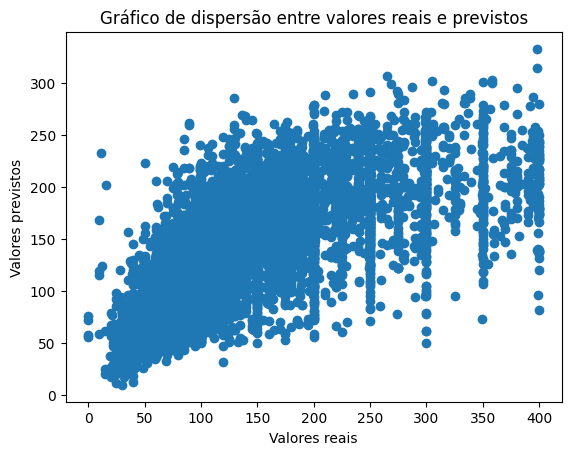

In [319]:
# Gerando um gráfico de dispersão entre os valores reais e os valores previstos
plt.scatter(y_test, y_pred_lgbm)
plt.xlabel("Valores reais")
plt.ylabel("Valores previstos")
plt.title("Gráfico de dispersão entre valores reais e previstos")
plt.show()

* Um MAPE de 28.49% significa que, em média, as previsões do modelo estão 28.49% distantes dos valores reais.
* O coeficiente de determinação (R²) do modelo é 0.55. Isso significa que o modelo explica aproximadamente 55% da variância na variável dependente que é previsível a partir das variáveis independentes. Isso indica um nível moderado de precisão.
* O erro quadrático médio (MSE) do modelo é 2768.90 e o erro quadrático médio raiz (RMSE) do modelo é 52.62. Esses valores indicam que há erros significativos entre os valores previstos e os valores reais, sugerindo espaço para melhoria na precisão do modelo.
* Observando o gráfico de dispersão entre os valores reais e os valores previstos, há uma dispersão notável nos valores previstos à medida que os valores reais aumentam; essa inconsistência implica que o modelo pode não ser muito confiável para prever valores mais altos.

A partir desses resultados e gráfico, podemos tirar as seguintes conclusões:

* O modelo tem um poder preditivo moderado, mas não é muito preciso.
* Ele pode ser mais confiável para previsões de valores mais baixos, mas mostra inconsistência em valores mais altos.

### Random Forest

In [320]:
# Definindo os hiperparâmetros
# Neste exemplo, vamos usar o número de árvores e a profundidade máxima como hiperparâmetros
# Pode se usar outros parâmetros, como criterion, min_samples_split, etc.
params =  {'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 5, 10, 15]}

# Criando o modelo
rfr = RandomForestRegressor()

# Criando a validação cruzada
skf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Realizando uma pesquisa em grade (grid search) para otimizar os hiperparâmetros de um modelo de regressão de random forest
grid_search  = GridSearchCV(rfr, param_grid=params, scoring='r2',
                            cv=skf.split(X_train, y_train))

# Treino do modelo com o grid search
grid_search.fit(X_train, y_train)
print('Melhores hiperparâmetros:')
print(grid_search.best_params_)


#  Criando o modelo com hiperparâmetros otimizados usando os melhores parâmetros encontrados na pesquisa em grade

rfr = RandomForestRegressor(n_estimators = grid_search.best_params_['n_estimators'],
                            max_depth = grid_search.best_params_['max_depth'])

# Treinando o modelo
rfr.fit(X_train, y_train)

# Usando o modelo para prever o conjunto de validação
y_pred_rfr = rfr.predict(X_test)

Melhores hiperparâmetros:
{'max_depth': 15, 'n_estimators': 200}


In [321]:
# Calculando o MAPE do modelo
mape = mean_absolute_error(y_test, y_pred_rfr) / y_test.mean() * 100
print(f"O MAPE do modelo é {mape:.2f}%")

# Calculando o R² do modelo
r2 = rfr.score(X_test, y_test)
print(f"O coeficiente de determinação do modelo é {r2:.2f}")

# Calculando o MSE do modelo
mse = mean_squared_error(y_test, y_pred_rfr)
print(f"O erro quadrático médio do modelo é {mse:.2f}")

# Calculando o RMSE do modelo
rmse = np.sqrt(mse)
print(f"O RMSE do modelo é {rmse:.2f}")

O MAPE do modelo é 28.59%
O coeficiente de determinação do modelo é 0.55
O erro quadrático médio do modelo é 2804.15
O RMSE do modelo é 52.95


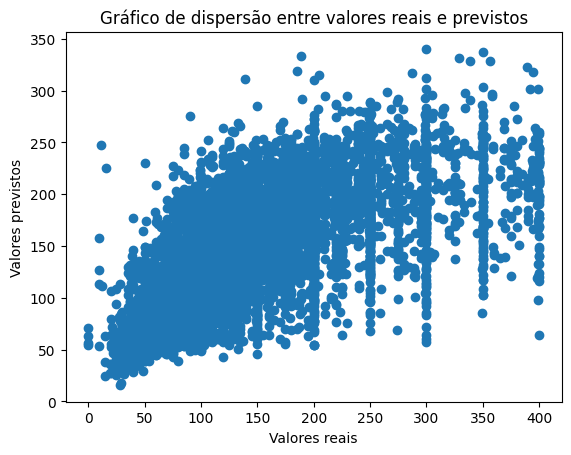

In [322]:
# Gerando um gráfico de dispersão entre os valores reais e os valores previstos
plt.scatter(y_test, y_pred_rfr)
plt.xlabel("Valores reais")
plt.ylabel("Valores previstos")
plt.title("Gráfico de dispersão entre valores reais e previstos")
plt.show()

* Um MAPE de 28.55% significa que, em média, as previsões do modelo estão 28.55% distantes dos valores reais
* O coeficiente de determinação (R²) do modelo é 0.55. Isso significa que o modelo explica 55% da variância na variável dependente que é previsível a partir das variáveis independentes. Isso indica um nível moderado de precisão.
* O erro quadrático médio (MSE) do modelo é 2799.82 e o erro quadrático médio raiz (RMSE) do modelo é 52.91. Esses valores indicam que há erros significativos entre os valores previstos e os valores reais, sugerindo espaço para melhoria na precisão do modelo.
* Observando o gráfico de dispersão entre os valores reais e os valores previstos, há uma concentração notável nos valores mais baixos, com dispersão aumentando à medida que os valores aumentam. Esse padrão como no anterior, tembém pode indicar que esse modelo de regressão de random forest tem um bom desempenho para previsões de valores mais baixos, mas se torna menos preciso à medida que os valores aumentam.

### LightGBM X Random Forest

* Os dois modelos treinados tem um MAPE quase iguais o modelo LightGBM com 28.49% e o modelo Random Forest com 28.55%.
* Ambos os modelo de random forest e LightGBM tem um coeficiente de determinação (R²) de 0.55.
* O modelo de random forest tem um erro quadrático médio (MSE) de 2799.82 e um erro quadrático médio raiz (RMSE) de 52.91, enquanto o modelo LightGBM tem um MSE de 2768.90 e um RMSE de 52.62. Isso significa que o modelo de LightGBM tem erros menores entre os valores previstos e os valores reais do que o modelo de Random forest, porém podemos considerar que houve um empate, pois essa diferença entre os modelos se torna quase nula.
* Observando os gráficos de dispersão entre os valores reais e os valores previstos, ambos os modelos mostram uma concentração nos valores mais baixos e uma dispersão nos valores mais altos. Isso indica que ambos os modelos têm um bom desempenho para previsões de valores mais baixos, mas se tornam menos precisos à medida que os valores aumentam.
* Mesmo com os modelos tendo tecnicamente empatados em suas predições, irei selecionar o LightGBM, por apresentar um tempo de treino menor que o Random Forest.

Em conclusão, o modelo de regressão de random forest e LightGBM apresentam precisões iguais. No entanto, ambos os modelos têm espaço para melhoria, especialmente para previsões de valores mais altos. Por questão de indisponibilidade de tempo, não conseguirei buscar melhorias para o modelo, algumas possiveis técnicas seriam tentar ajustar os parâmetros dos modelos, selecionar melhores características ou usar outras técnicas de modelagem para aumentar a precisão das previsões.

# Prevendo valor de um apartamento

{'id': 2595,

 'nome': 'Skylit Midtown Castle',

 'host_id': 2845,

 'host_name': 'Jennifer',

 'bairro_group': 'Manhattan',

 'bairro': 'Midtown',

 'latitude': 40.75362,

 'longitude': -73.98377,

 'room_type': 'Entire home/apt',

 'minimo_noites': 1,

 'numero_de_reviews': 45,

 'ultima_review': '2019-05-21',

 'reviews_por_mes': 0.38,

 'calculado_host_listings_count': 2,
 
 'disponibilidade_365': 355}

* Primeiro valor será Latitude: 40.75362.
* O segundo será longitude: -73.98377.
* Terceiro valor será 1, número minimo de noites.
* Quarto será 8, pois tem 45 reviews que se encaixa no seguinte grupo: Classificamos como 8 os valores entre 41 e 90 reviews.
* Quinto será 2, pois se encaixa no grupo: Classificamos como 2 os valores com 2 e 3 listagens por host.
* Sexto será 5, pois a ultima Review foi feita no mês 5 (Maio).
* Sétimo será 3, já que 0.38 reviews por mês se encaixa no grupo: Classificamos como 3 os valores entre 0.25 e 0.5 reviews.
* Oitavo valor será 12, já que a disponibilidade de 355 dias se encaixa em: Classificamos como 12 meses os valores de 331 a 365.
* O primeiro Dummie será, (0, 0, 1, 0, 0), pois o apartamento se encontra no bairro_group Manhattan.
* O segundo dummie um apartamento Entire home/apt que também será (1, 0, 0).

In [323]:
X_test.head()

,latitude,longitude,minimo_noites,classificacao_reviews,classificacao_reviews_por_mes,classificacao_hosts,mes_analise,classificacao_disponibilidade,bairro_group_bronx,bairro_group_brooklyn,bairro_group_manhattan,bairro_group_queens,bairro_group_staten_island,room_type_entire_home/apt,room_type_private_room,room_type_shared_room
11328,40.63976,-73.96419,7,6,3,3,8,5,0,1,0,0,0,0,1,0
25830,40.69574,-73.93975,2,1,1,2,0,6,0,1,0,0,0,0,1,0
6733,40.82376,-73.94492,25,6,3,1,7,6,0,0,1,0,0,1,0,0
28127,40.71991,-73.98832,10,1,1,1,0,1,0,0,1,0,0,0,1,0
46559,40.71413,-73.93701,3,2,6,1,6,5,0,1,0,0,0,1,0,0


In [324]:
# Pondo valores da entrada
nova_entrada = [[40.75362, -73.98377, 1, 8, 2, 5, 3, 12, 0, 0, 1, 0, 0, 1, 0, 0]]
# Usando o método predict do modelo para gerar uma previsão
previsao = lgbm_r.predict(nova_entrada)
# Imprimindo a previsão
print(previsao)

[206.01218366]


O modelo sugeriu um valor de  206.01218366 dólares.

## Gerando arquivo .pkl

In [113]:
# importando a biblioteca pickle
import pickle

# salvando o modelo em um arquivo
with open('lgbm_model.pkl', 'wb') as file:
  pickle.dump(lgbm_r, file)

## Gerando o Arquivo de Requisitos

In [ ]:
pip install -r requirements.txt

In [ ]:
pip freeze > requirements.txt